In [1]:
# import logging
import os
import re
from pathlib import Path
from collections import Counter

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc
import seaborn as sns
import torch
import yaml
from einops import rearrange

In [2]:
%load_ext autoreload

In [3]:
%autoreload 2

In [4]:
from mushroom.mushroom_v4 import Mushroom
import mushroom.utils as utils

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packag

In [5]:
run_dir = '/data/estorrs/mushroom/data/projects/subclone'
mushroom_dir = os.path.join(run_dir, 'mushroom')
config_fps = sorted(utils.listfiles(mushroom_dir, regex=r'/config.yaml'))
config_fps

['/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT206B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT225C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT226C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT235B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H3/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT243B1-H4/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT271B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT339B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT413C1/config.yaml',
 '/data/estorrs/mushroom/data/projects/subclon

In [6]:
mushroom_config = {
    'dtype': 'visium',
#     'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'triplet_scaler': .001,
        'recon_scaler': 1.,
        'encoder_dim': 256,
        'decoder_dim': 256,
    },
    'learner_kwargs': {
        'scale': .1,
        'pct_expression': .02,
        'batch_size': 32,
        'num_workers': 1,
        'device': 'cuda:1',
#         'channels': channels,
#         'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 10000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 1000,
#         'save_dir': chkpt_dir       
    },
    'cluster_kwargs': {
        'num_clusters': 20,
        'mask_background': True,
        'margin': .05,
        'background_channels': None,
        'span_all_sections': True,
        'centroids': None,
    }
}

In [7]:
# config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT112C1/config.yaml'
config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml'

# config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml'
case = config_fp.split('/')[-2]
out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/subclone/mushroom/{case}_vae_vq/outputs')

# config_fp = '/data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2'
# out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/subclone/mushroom/{case}_vq/outputs')


config = yaml.safe_load(open(config_fp))

chkpt_dir = os.path.join(out_dir, 'chkpts')
Path(chkpt_dir).mkdir(parents=True, exist_ok=True)

In [8]:
mushroom_config['sections'] = config
mushroom_config['train_kwargs']['save_dir'] = chkpt_dir
mushroom_config['chkpt_filepath'] = os.path.join(chkpt_dir, 'final.pt')

In [9]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:using device: cuda:1
INFO:root:generating inputs for visium tissue sections
INFO:root:using 13417 channels
INFO:root:5 sections detected: ['s0', 's1', 's2', 's3', 's4']
INFO:root:processing sections
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized
INFO:root:initializing clusterer
INFO:root:no background channel detected, defaulting to mean of all channels


In [10]:
mushroom.embed_sections()

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's1'}>, <Axes: title={'center': 's2'}>,
        <Axes: title={'center': 's3'}>, <Axes: title={'center': 's4'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

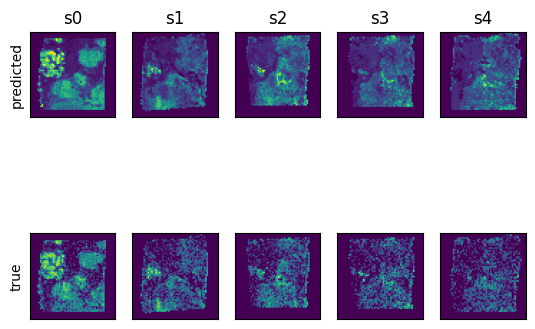

In [11]:
mushroom.display_predicted_pixels(channel='EPCAM')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's1'}>, <Axes: title={'center': 's2'}>,
        <Axes: title={'center': 's3'}>, <Axes: title={'center': 's4'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

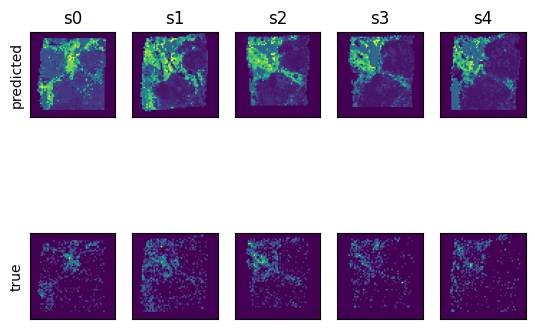

In [12]:
mushroom.display_predicted_pixels(channel='IL7R')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's1'}>, <Axes: title={'center': 's2'}>,
        <Axes: title={'center': 's3'}>, <Axes: title={'center': 's4'}>],
       [<Axes: ylabel='true'>, <Axes: >, <Axes: >, <Axes: >, <Axes: >]],
      dtype=object)

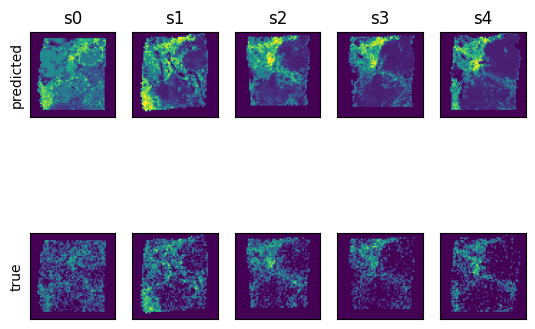

In [13]:
mushroom.display_predicted_pixels(channel='CD68')

In [14]:
mushroom.cluster_sections(margin=.1)

INFO:root:no background channel detected, defaulting to mean of all channels
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/joblib/externals/loky/backend/context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[Errno 13] Permission denied: 'lscpu'
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/joblib/externals/loky/backend/context.py", line 250, in _count_physical_cores
    cpu_info = subprocess.run(
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/subprocess.py", line 505, in run
    with Popen(*popenargs, **kwargs) as process:
  File "/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/subprocess.py", line 951, in __init__
    self._execute_child(args, executable, preexec_fn, close_fds,
  File "/data/estorrs/miniconda3/en

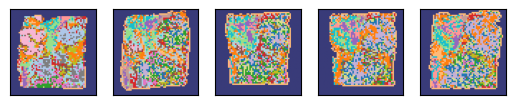

In [15]:
mushroom.clusterer.display_cluster_ids(mushroom.cluster_ids)

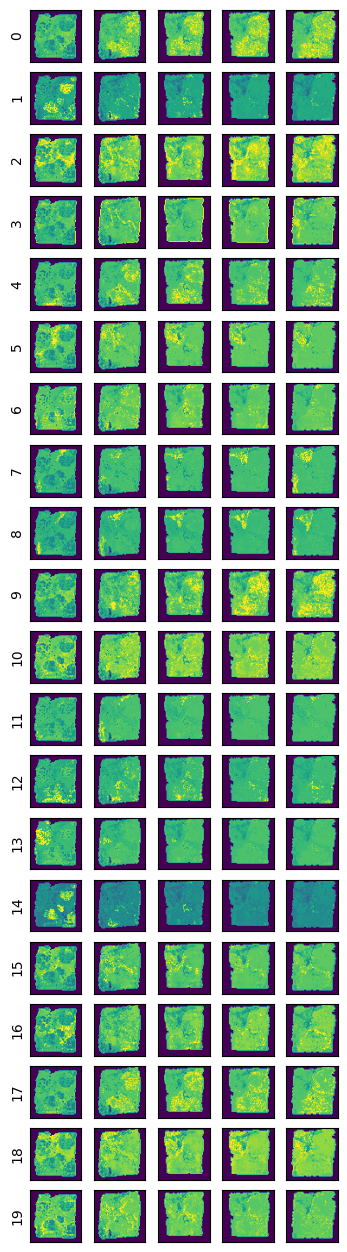

In [16]:
mushroom.clusterer.display_distances(mushroom.dists, figsize=(4, 16))

In [98]:
def relabel(labels):
    new = np.zeros_like(labels, dtype=labels.dtype)
    ids = np.unique(labels)
    for i in range(len(ids)):
        new[labels==ids[i]] = i
        
    return new

cluster_ids = dists.argmin(-1).numpy()
cluster_ids = relabel(cluster_ids)
cluster_ids.shape

(5, 60, 60)

In [99]:
import seaborn as sns
from mushroom.visualization.utils import display_labeled_as_rgb

In [100]:
def show_legend(ids, cmap):
    labels = np.unique(ids)
    fig, axs = plt.subplots(ncols=len(labels))
    for n, l in enumerate(labels):
        axs[n].imshow(rearrange(np.asarray(cmap[l]), 'n -> 1 1 n'))
        axs[n].axis('off')
        axs[n].set_title(str(l), rotation=90)


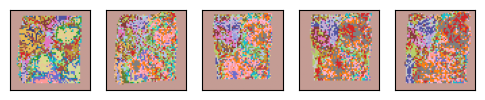

In [101]:
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
cmap += cmap
cmap += cmap
fig, axs = plt.subplots(ncols=cluster_ids.shape[0], figsize=(6, 4))
for i, labeled in enumerate(cluster_ids):
    axs[i].imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    axs[i].set_xticks([])
    axs[i].set_yticks([])

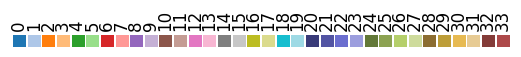

In [102]:
show_legend(cluster_ids, cmap)

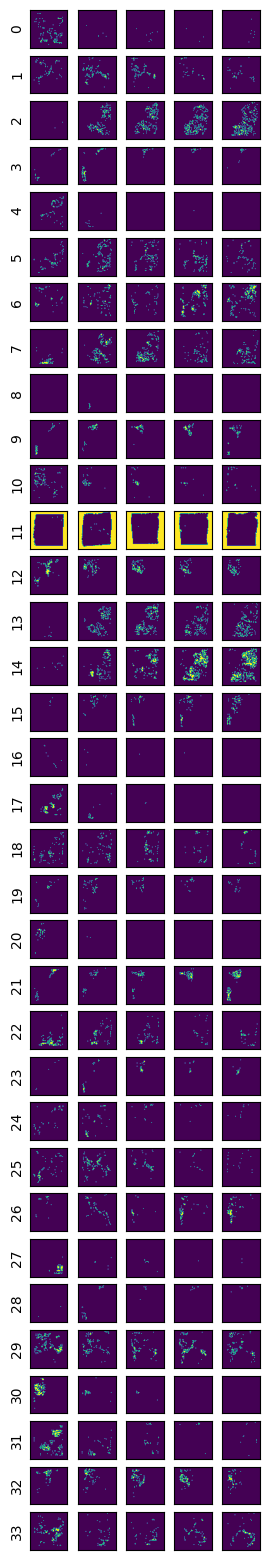

In [111]:
fig, axs = plt.subplots(nrows=cluster_ids.max() + 1, ncols=cluster_ids.shape[0], figsize=(3, 20))
for i in range(cluster_ids.max() + 1):
    for j in range(cluster_ids.shape[0]):
        ax = axs[i, j]
        ax.imshow(cluster_ids[j] == i)
#         ax.axis('off')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_xlabel('')
        ax.set_ylabel('')
        
        if j == 0:
            ax.set_ylabel(i)
            

In [128]:
exp = []
for i in range(cluster_ids.max() + 1):
    mask = cluster_ids == i
    x = rearrange(mushroom.recon_imgs, 'n d h w -> d n h w')
    exp.append(x[:, mask].mean(-1))
exp = torch.stack(exp)
exp = pd.DataFrame(data=exp.numpy(), columns=mushroom.learner.channels)
exp = exp[~pd.isnull(exp.iloc[:, 0])]
exp


A1BG  A1BG-AS1      A1CF       A2M     A2ML1    A4GALT      AAAS  \
0  -0.160118  0.199095 -0.219669  0.205425  0.138341  0.242662  0.353163   
1  -0.167880 -0.036721 -0.179811  0.197898 -0.397196  0.089621 -0.186103   
2  -0.461804 -0.112335 -0.211343 -0.579283  0.084842 -0.143435 -0.174249   
3   1.923114  0.085878  1.672039  1.487268 -0.065837  0.128824  0.386476   
4   0.141422  0.503146 -0.140635  0.651180  0.724538  0.227245  0.785558   
5  -0.169223  0.003114 -0.151011 -0.108184 -0.006571 -0.036939 -0.037453   
6  -0.668673 -0.210937 -0.255446 -0.714747 -0.397274 -0.130596 -0.435490   
7  -0.182418  0.083418 -0.200906 -0.366580  0.522053 -0.111366  0.126082   
8   0.854204  0.443436  0.397093  0.886658  2.136480 -0.078143  1.372390   
9   2.663563 -0.077603  1.994539  1.773546 -0.391660  0.084251  0.197249   
10 -0.175788  0.062354 -0.167306  0.133358 -0.321234  0.099725  0.027086   
11 -0.894287 -0.275057 -0.294492 -0.989959 -0.555908 -0.183902 -0.582619   
12  0.382288 -0.016123 -0.006736  1.029112 -0.455466  0.437437 -0.120497   
13 -0.328906 -0.039336 -0.208100 -0.468288  0.300913 -0.135358 -0.046061   
14 -0.571017 -0.148507 -0.233043 -0.671396 -0.108838 -0.146702 -0.292401   
15  0.555991 -0.118531  0.093578  0.329980 -0.437408 -0.013126 -0.262657   
16  0.038303  0.013819 -0.153365  3.922721 -0.386162  2.831319  0.258879   
17  0.160599  0.577290 -0.204550  0.325563  1.691213 -0.031033  1.167786   
18  0.075082  0.229478 -0.074672  0.104560  0.411700  0.003400  0.340548   
19  1.203082 -0.038626  0.654791  1.558861 -0.429586  0.300799  0.069203   
20 -0.012679  0.537564 -0.201761  0.507285 -0.363255  0.148555  1.280926   
21  1.896960 -0.106078  1.074637  1.261422 -0.407776  0.087563 -0.009168   
22  0.007814  0.281477 -0.186099 -0.195985  1.035577 -0.073228  0.501764   
23  2.980199  0.173363  2.949493  2.220039 -0.293342  0.182043  0.477980   
24  0.605001  0.258977  0.297218  1.037830  0.092614  0.215618  0.424653   
25  0.071538  0.036632 -0.086887  0.599534 -0.183646  0.152572  0.042673   
26 -0.852744 -0.269097 -0.285564 -0.942069 -0.544640 -0.174383 -0.566993   
27  0.244475  0.558239 -0.231409  0.003989  1.928947 -0.021693  1.139147   
28  2.276659  0.322364  2.446991  1.904320  0.116647  0.263621  0.683497   
29 -0.404851 -0.143488 -0.210608 -0.319836 -0.444557 -0.035192 -0.352573   
30 -0.150586  0.413405 -0.254240  0.260766 -0.293907  0.099425  0.697898   
31  0.087124  0.409437 -0.145584  0.174116  1.206849 -0.022653  0.823016   
32  0.024336 -0.096597 -0.116695  0.224101 -0.497427  0.102123 -0.285955   
33 -0.389330 -0.075125 -0.205738 -0.368499 -0.241701 -0.056681 -0.209032   

        AACS     AADAC     AADAT  ...      ZUP1      ZW10    ZWILCH     ZWINT  \
0   0.210865 -0.277159  0.009619  ...  0.101173  0.176350  0.041306  0.006370   
1  -0.227192 -0.201515 -0.176492  ... -0.196023 -0.224913 -0.268145 -0.382874   
2  -0.072846 -0.296195 -0.066380  ... -0.074628 -0.107873 -0.043965  0.092270   
3   0.089963  1.989680  0.353798  ...  0.075155  0.223410  0.006360 -0.016305   
4   0.551302 -0.156978  0.336288  ...  0.665090  0.726086  0.745796  0.822033   
5  -0.024088 -0.213993 -0.052807  ... -0.015170  0.015920 -0.005926 -0.020422   
6  -0.339972 -0.347127 -0.234756  ... -0.313888 -0.353790 -0.339627 -0.389304   
7   0.215665 -0.246457  0.153186  ...  0.213982  0.213915  0.316159  0.469075   
8   0.616604  0.305207  1.050035  ...  2.019329  1.346491  1.845567  2.224607   
9  -0.072306  2.836567  0.293941  ... -0.133530 -0.052999 -0.229093 -0.335823   
10  0.035037 -0.232498 -0.031998  ... -0.088839 -0.073830 -0.052884 -0.183414   
11 -0.449063 -0.381402 -0.304465  ... -0.401037 -0.457823 -0.456977 -0.618018   
12 -0.151916  0.100671 -0.162687  ... -0.253456 -0.229883 -0.307557 -0.446070   
13  0.066646 -0.276540  0.032339  ...  0.049443  0.038383  0.142927  0.273987   
14 -0.209725 -0.319356 -0.138256  ... -0.175744 -0.230659 -0.190172 -0.095693   
15 -0.227986  0.187805 -0.152666  ... -0.238028 -0.

In [130]:
from sklearn.cluster import AgglomerativeClustering
dist = 30.
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=dist).fit(exp.values)
# clustering = AgglomerativeClustering(n_clusters=10, distance_threshold=None).fit(exp.values)
cluster_to_label = {c:l for c, l in zip(exp.index, clustering.labels_)}
neigh_ids = np.vectorize(cluster_to_label.get)(cluster_ids)
len(np.unique(neigh_ids))

19

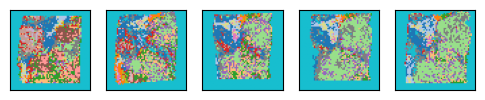

In [131]:
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
cmap += cmap
cmap += cmap
fig, axs = plt.subplots(ncols=neigh_ids.shape[0], figsize=(6, 4))
for i, labeled in enumerate(neigh_ids):
    axs[i].imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    axs[i].set_xticks([])
    axs[i].set_yticks([])

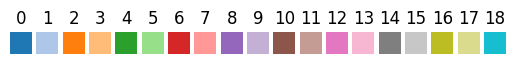

In [132]:
labels = np.unique(neigh_ids)
fig, axs = plt.subplots(ncols=len(labels))
for n, l in enumerate(labels):
    axs[n].imshow(rearrange(np.asarray(cmap[l]), 'n -> 1 1 n'))
    axs[n].axis('off')
    axs[n].set_title(str(l))
    

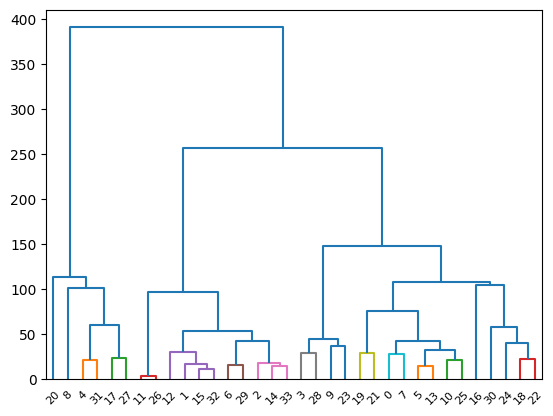

In [133]:
import scipy.cluster.hierarchy as shc
links = shc.linkage(exp.values, method ='ward')
dendrogram = shc.dendrogram((links), color_threshold=dist, labels=exp.index.to_list())

In [152]:
mushroom.learner.inference_ds.section_to_img['s0'].shape

torch.Size([1, 1888, 1964])

In [153]:
torch.unique(mushroom.learner.inference_ds.section_to_img['s0'])

tensor([   0,    1,    2,  ..., 4233, 4234, 4235])

In [155]:
mushroom.learner.inference_ds.section_to_tiles['s0'].shape

torch.Size([15, 15, 1, 256, 256])

In [183]:
256 / 8

32.0

In [ ]:
mushroom.learner.inference_ds.section_to_tiles

In [165]:
ds = mushroom.learner.inference_ds

imgs = []
for idx in range(len(ds)):
    section_idx, row_idx, col_idx = ds.idx_to_coord[idx]
    section = ds.sections[section_idx]
    img = ds.section_to_tiles[section][row_idx, col_idx]
    imgs.append(img)
imgs = torch.stack(imgs)

recon_labeled = torch.stack(
    [ds.section_from_tiles(
        imgs, i,
#         size=(mushroom.learner.train_transform.output_size[0], mushroom.learner.train_transform.output_size[1])
    ) for i in range(len(ds.sections))]
)

In [258]:
recon_labeled.shape

torch.Size([5, 1, 1920, 1920])

In [259]:
import torchvision.transforms.functional as TF
patch_size = 32
resized_cluster_ids = TF.resize(
    torch.tensor(cluster_ids),
    (recon_labeled.shape[-2], recon_labeled.shape[-1]),
    antialias=False,
    interpolation=TF.InterpolationMode.NEAREST
).numpy()
resized_cluster_ids.shape

(5, 1920, 1920)

In [282]:
from skimage.measure import regionprops

for section_idx in range(len(ds.sections)):
    section = ds.sections[section_idx]
    a = ds.section_to_adata[section]
    labeled = recon_labeled[section_idx]

    props = regionprops(labeled.to(torch.int32).numpy())
    a.obsm['spatial_scaled'] = np.zeros_like(a.obsm['spatial'])
    for prop in props:
        _, r, c = prop.centroid
        a.obsm['spatial_scaled'][prop.label - 1] = [c, r]
        
    ds.section_to_adata[section] = a

In [283]:
a.obs

in_tissue  array_row  array_col  FC1     FC2  \
HT268B1-U32_AAACAAGTATCTCCCA-1          1         50        102  0.0     0.0   
HT268B1-U32_AAACACCAATAACTGC-1          1         59         19  3.0   466.0   
HT268B1-U32_AAACAGAGCGACTCCT-1          1         14         94  4.0   617.0   
HT268B1-U32_AAACAGCTTTCAGAAG-1          1         43          9  4.0   614.0   
HT268B1-U32_AAACAGGGTCTATATT-1          1         47         13  7.0  1393.0   
...                                   ...        ...        ...  ...     ...   
HT268B1-U32_TTGTTGTGTGTCAAGA-1          1         31         77  7.0  1296.0   
HT268B1-U32_TTGTTTCACATCCAGG-1          1         58         42  0.0     0.0   
HT268B1-U32_TTGTTTCATTAGTCTA-1          1         60         30  2.0   232.0   
HT268B1-U32_TTGTTTCCATACAACT-1          1         45         27  7.0  1234.0   
HT268B1-U32_TTGTTTGTATTACACG-1          1         73         41  0.0     0.0   

                                FC3     FC4      FC5     FC6  \
HT268B1-U32_AAACAAGTATCTCCCA-1  0.0     0.0      0.0     0.0   
HT268B1-U32_AAACACCAATAACTGC-1  3.0   466.0      3.0   466.0   
HT268B1-U32_AAACAGAGCGACTCCT-1  4.0   617.0      4.0   617.0   
HT268B1-U32_AAACAGCTTTCAGAAG-1  4.0   614.0      4.0   614.0   
HT268B1-U32_AAACAGGGTCTATATT-1  8.0  1453.0  unknown     0.0   
...                             ...     ...      ...     ...   
HT268B1-U32_TTGTTGTGTGTCAAGA-1  7.0  1296.0      7.0  1296.0   
HT268B1-U32_TTGTTTCACATCCAGG-1  0.0     0.0      0.0     0.0   
HT268B1-U32_TTGTTTCATTAGTCTA-1  2.0   232.0      2.0   232.0   
HT268B1-U32_TTGTTTCCATACAACT-1  7.0  1234.0      7.0  1234.0   
HT268B1-U32_TTGTTTGTATTACACG-1  0.0     0.0      0.0     0.0   

                                Filtered tumor regions  ...  Tumor boundary  \
HT268B1-U32_AAACAAGTATCTCCCA-1                     0.0  ...             NaN   
HT268B1-U32_AAACACCAATAACTGC-1                     1.0  ...             NaN   
HT268B1-U32_AAACAGAGCGACTCCT-1                     2.0  ...             NaN   
HT268B1-U32_AAACAGCTTTCAGAAG-1                     1.0  ...             NaN   
HT268B1-U32_AAACAGGGTCTATATT-1                     1.0  ...             NaN   
...                                                ...  ...             ...   
HT268B1-U32_TTGTTGTGTGTCAAGA-1                     2.0  ...             NaN   
HT268B1-U32_TTGTTTCACATCCAGG-1                     0.0  ...             NaN   
HT268B1-U32_TTGTTTCATTAGTCTA-1                     1.0  ...             NaN   
HT268B1-U32_TTGTTTCCATACAACT-1                     1.0  ...             NaN   
HT268B1-U32_TTGTTTGTATTACACG-1                     0.0  ...             NaN   

                               Tumor regions  Tumor vs. TME  \
HT268B1-U32_AAACAAGTATCTCCCA-1           0.0            TME   
HT268B1-U32_AAACACCAATAACTGC-1           1.0          Tumor   
HT268B1-U32_AAACAGAGCGACTCCT-1           2.0          Tumor   
HT268B1-U32_AAACAGCTTTCAGAAG-1           1.0          Tumor   
HT268B1-U32_AAACAGGGTCTATATT-1           1.0          Tumor   
...                                      ...            ...   
HT268B1-U32_TTGTTGTGTGTCAAGA-1           2.0          Tumor   
HT268B1-U32_TTGTTTCACATCCAGG-1           0.0            TME   
HT268B1-U32_TTGTTTCATTAGTCTA-1           1.0          Tumor   
HT268B1-U32_TTGTTTCCATACAACT-1           1.0          Tumor   
HT268B1-U32_TTGTTTGTATTACACG-1           0.0            TME   

                                           barcode                library_id  \
HT268B1-U32_AAACAAGTATCTCCCA-1  AAACAAGTATCTCCCA-1  HT268B1-Th1H3Fc2U32Z1Bs1   
HT268B1-U32_AAACACCAATAACTGC-1  AAACACCAATAACTGC-1  HT268B1-Th1H3Fc2U32Z1Bs1   
HT268B1-U32_AAACAGAGCGACTCCT-1  AAACAGAGCGACTCCT-1  HT268B1-Th1H3Fc2U32Z1Bs1   
HT268B1-U32_AAACAGCTTTCAGAAG-1  AAACAGCTTTCAGAAG-1  HT268B1-Th1H3Fc2U32Z1Bs1   
HT268B1-U32_AAACAGGGTCTATATT-1  AAACAGGGTCTATATT-1  HT268B1-Th1H3Fc2U32Z1Bs1   
...                                            ...                       ...   
HT268B1-U32_TTGTTGTGTGTCAAGA-1  TTGT

In [284]:
for section_idx in range(len(ds.sections)):
    section = ds.sections[section_idx]
    a = ds.section_to_adata[section]
    
    a.obs['cluster'] = [str(resized_cluster_ids[section_idx, r, c]) for c, r in a.obsm['spatial_scaled']]
    ds.section_to_adata[section] = a

In [285]:
tups = [(sub, clust) for a in ds.section_to_adata.values()
        for sub, clust in zip(a.obs['subclone'], a.obs['cluster'])]

In [286]:
subclone_counts = Counter([v for a in ds.section_to_adata.values() for v in a.obs['subclone']])
cluster_counts = Counter([v for a in ds.section_to_adata.values() for v in a.obs['cluster']])
tup_counts = Counter(tups)

In [287]:
tup_counts

Counter({('clone_2', '14'): 2234,
         ('clone_2', '2'): 1766,
         ('clone_2', '13'): 1491,
         ('', '29'): 1266,
         ('clone_2', '7'): 1185,
         ('', '12'): 910,
         ('', '32'): 827,
         ('', '21'): 712,
         ('clone_2', '6'): 657,
         ('', '33'): 653,
         ('', '1'): 652,
         ('clone_2', '22'): 628,
         ('clone_2', '31'): 581,
         ('clone_2', '5'): 524,
         ('', '9'): 517,
         ('', '25'): 516,
         ('', '5'): 475,
         ('', '15'): 470,
         ('', '6'): 469,
         ('', '26'): 465,
         ('clone_2', '18'): 461,
         ('clone_1', '30'): 311,
         ('', '3'): 299,
         ('', '10'): 267,
         ('clone_2', '17'): 251,
         ('', '19'): 249,
         ('', '23'): 181,
         ('', '24'): 171,
         ('', '18'): 170,
         ('clone_2', '33'): 161,
         ('clone_2', '27'): 155,
         ('', '0'): 155,
         ('clone_2', '4'): 131,
         ('clone_1', '10'): 122,
         ('', '14

In [288]:
data = []
for cluster in range(len(cluster_counts)):
    cluster_count = cluster_counts[str(cluster)]
    for subclone, subclone_count in subclone_counts.items():
        row = [str(cluster), subclone]
        count = tup_counts.get((subclone, str(cluster)), 0)
        row += [count, count / cluster_count, count / subclone_count]
        data.append(row)

count_df = pd.DataFrame(
    data=data,
    columns=['cluster', 'subclone', 'count', 'cluster_fraction', 'subclone_fraction'],
)
count_df

cluster subclone  count  cluster_fraction  subclone_fraction
0         0             155          0.559567           0.015614
1         0  clone_2    103          0.371841           0.009766
2         0  clone_1     19          0.068592           0.027941
3         1             652          0.987879           0.065679
4         1  clone_2      5          0.007576           0.000474
..      ...      ...    ...               ...                ...
97       32  clone_2      0          0.000000           0.000000
98       32  clone_1      0          0.000000           0.000000
99       33             653          0.786747           0.065780
100      33  clone_2    161          0.193976           0.015265
101      33  clone_1     16          0.019277           0.023529

[102 rows x 5 columns]

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33]),
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23'),
  Text(24, 0, '24'),
  Text(25, 0, '25'),
  Text(26, 0, '26'),
  Text(27, 0, '27'),
  Text(28, 0, '28'),
  Text(29, 0, '29'),
  Text(30, 0, '30'),
  Text(31, 0, '31'),
  Text(32, 0, '32'),
  Text(33, 0, '33')])

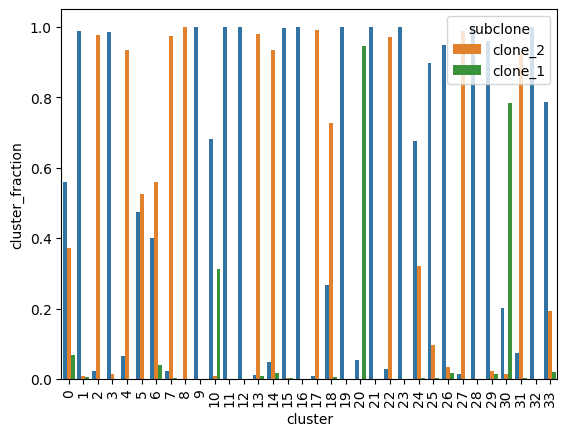

In [289]:
sns.barplot(data=count_df, x='cluster', y='cluster_fraction', hue='subclone')
plt.xticks(rotation=90)

In [298]:
cut = .5
clone_to_cluster = {clone:[] for clone in subclone_counts.keys() if clone}
for i, row in count_df.iterrows():
    if row['cluster_fraction'] > cut:
        if row['subclone']:
            clone_to_cluster[row['subclone']].append(row['cluster'])
cluster_to_clone = {v:k for k, vs in clone_to_cluster.items() for v in vs}
tme_cluster_to_orig = [c for c in sorted(set(count_df['cluster']))
                       if c not in cluster_to_clone]
clone_to_cluster, tme_cluster_to_orig

({'clone_2': ['2',
   '4',
   '5',
   '6',
   '7',
   '8',
   '13',
   '14',
   '17',
   '18',
   '22',
   '27',
   '31'],
  'clone_1': ['20', '30']},
 ['0',
  '1',
  '10',
  '11',
  '12',
  '15',
  '16',
  '19',
  '21',
  '23',
  '24',
  '25',
  '26',
  '28',
  '29',
  '3',
  '32',
  '33',
  '9'])

In [299]:
def relabel_cluster(cluster):
    if cluster in cluster_to_clone:
        return cluster_to_clone[cluster]
    idx = tme_cluster_to_orig.index(cluster)
    return f'TME_{idx}'
    

for section, a in ds.section_to_adata.items():
    a.obs['relabeled_clusters'] = [relabel_cluster(cluster) for cluster in a.obs['cluster']]

... storing 'relabeled_clusters' as categorical


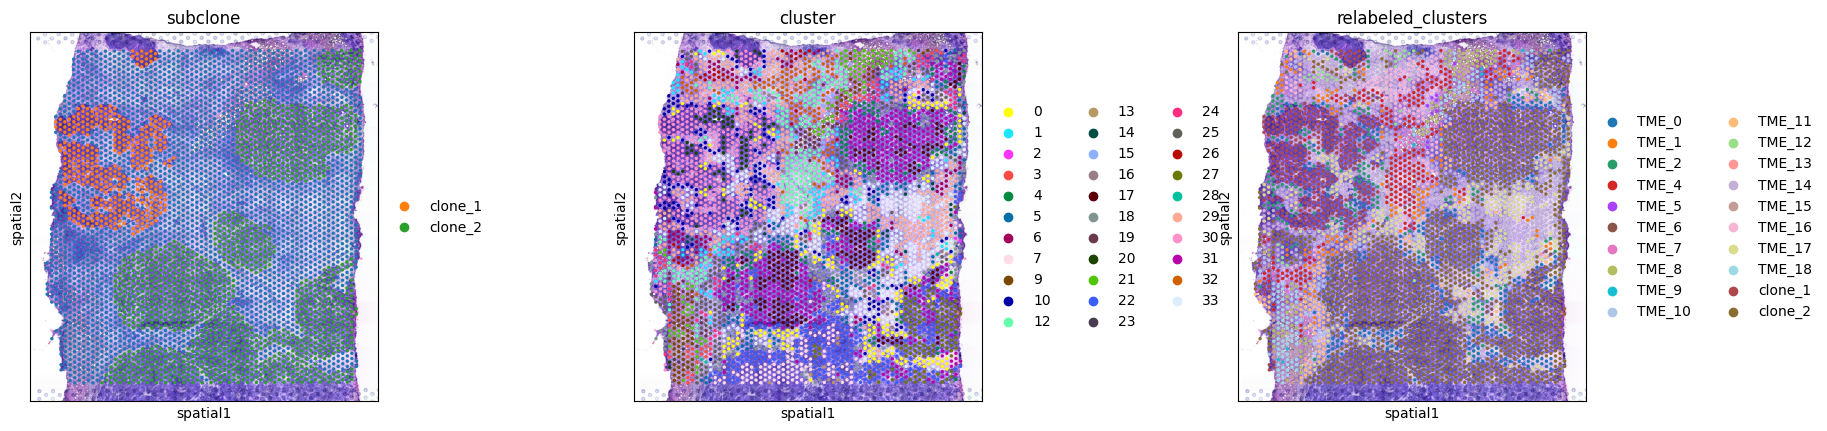

In [301]:
a = ds.section_to_adata['s0']
# a.obs['highlight'] = ['yes' if c=='12' else 'no' for c in a.obs['cluster']]
sc.pl.spatial(a, color=['subclone', 'cluster', 'relabeled_clusters'])

In [304]:
data = []

clusters = sorted(set([v for a in ds.section_to_adata.values() for v in a.obs['relabeled_clusters']]))
for section in ds.sections:
    a = ds.section_to_adata[section]
    counts = Counter(a.obs['relabeled_clusters'])
    for cluster in clusters:
        data.append([cluster, section, counts.get(cluster, 0), counts.get(cluster, 0) / a.shape[0]])
df = pd.DataFrame(data, columns=['cluster', 'section', 'count', 'spot_fraction'])
df 

cluster section  count  spot_fraction
0      TME_0      s0    237       0.055962
1      TME_1      s0    128       0.030224
2     TME_10      s0     75       0.017710
3     TME_11      s0    144       0.034002
4     TME_12      s0     35       0.008264
..       ...     ...    ...            ...
100    TME_7      s4     31       0.007519
101    TME_8      s4    263       0.063789
102    TME_9      s4     27       0.006549
103  clone_1      s4      0       0.000000
104  clone_2      s4   2534       0.614601

[105 rows x 4 columns]

<Axes: xlabel='section', ylabel='spot_fraction'>

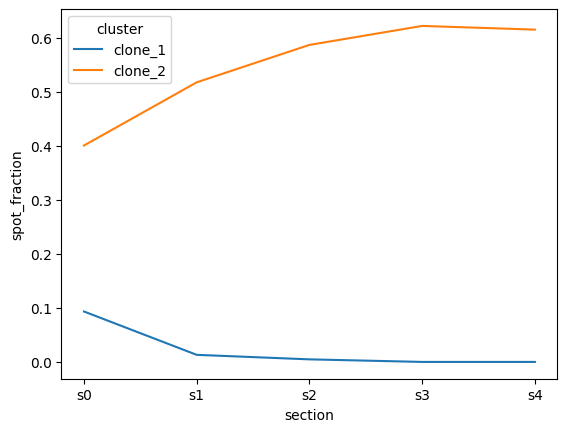

In [308]:
f = df[[True if 'clone' in c else False for c in df['cluster']]]
sns.lineplot(data=f, x='section', y='spot_fraction', hue='cluster')

/tmp/ipykernel_142488/2014638585.py:2: UserWarning: The palette list has more values (20) than needed (19), which may not be intended.
  sns.lineplot(data=f, x='section', y='spot_fraction', hue='cluster',


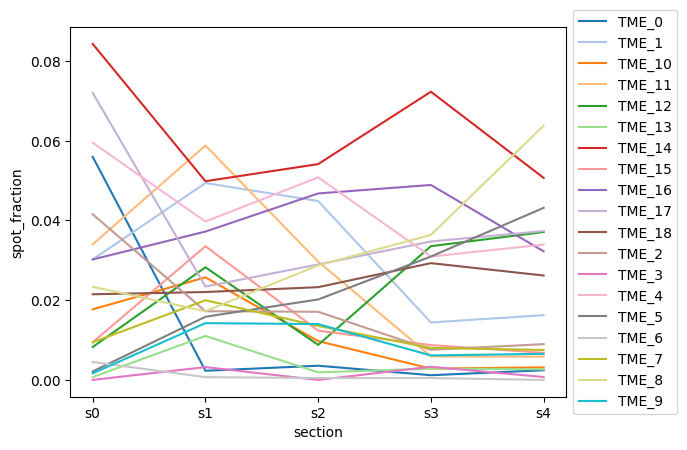

In [311]:
f = df[[True if 'TME' in c else False for c in df['cluster']]]
sns.lineplot(data=f, x='section', y='spot_fraction', hue='cluster',
             palette=sns.color_palette('tab20'))
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [329]:
def plot_change(cluster, column='relabeled_clusters'):
    fig, axs = plt.subplots(ncols=len(ds.sections))
    for i, section in enumerate(ds.sections):
        a = ds.section_to_adata[section]
        ax = axs[i]

        a.obs['highlight'] = ['yes' if c==cluster else 'no' for c in a.obs[column]]
        sc.pl.spatial(a, color=['highlight'], ax=ax, show=False, alpha_img=.5, legend_loc=None)
        ax.axis('off')
        ax.set_title(section)

... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical


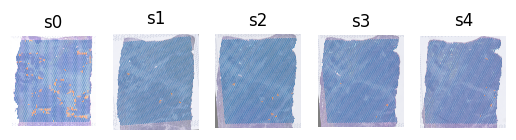

In [320]:
plot_change('TME_0')

... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical


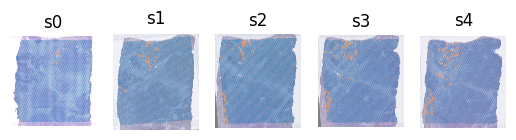

In [322]:
plot_change('TME_5')

... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical


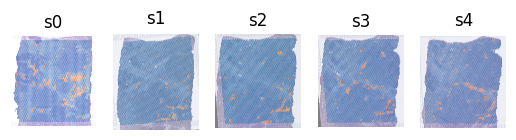

In [323]:
plot_change('TME_17')

... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical


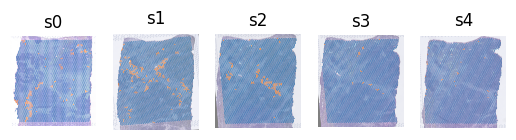

In [324]:
plot_change('TME_11')

... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical
... storing 'highlight' as categorical


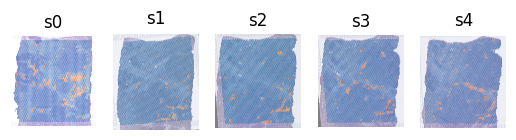

In [331]:
plot_change(tme_cluster_to_orig[17], column='cluster')

In [326]:
exp.sort_values('MYC', ascending=False)

A1BG  A1BG-AS1      A1CF       A2M     A2ML1    A4GALT      AAAS  \
8   0.854204  0.443436  0.397093  0.886658  2.136480 -0.078143  1.372390   
17  0.160599  0.577290 -0.204550  0.325563  1.691213 -0.031033  1.167786   
27  0.244475  0.558239 -0.231409  0.003989  1.928947 -0.021693  1.139147   
31  0.087124  0.409437 -0.145584  0.174116  1.206849 -0.022653  0.823016   
4   0.141422  0.503146 -0.140635  0.651180  0.724538  0.227245  0.785558   
22  0.007814  0.281477 -0.186099 -0.195985  1.035577 -0.073228  0.501764   
18  0.075082  0.229478 -0.074672  0.104560  0.411700  0.003400  0.340548   
7  -0.182418  0.083418 -0.200906 -0.366580  0.522053 -0.111366  0.126082   
24  0.605001  0.258977  0.297218  1.037830  0.092614  0.215618  0.424653   
0  -0.160118  0.199095 -0.219669  0.205425  0.138341  0.242662  0.353163   
28  2.276659  0.322364  2.446991  1.904320  0.116647  0.263621  0.683497   
13 -0.328906 -0.039336 -0.208100 -0.468288  0.300913 -0.135358 -0.046061   
5  -0.169223  0.003114 -0.151011 -0.108184 -0.006571 -0.036939 -0.037453   
20 -0.012679  0.537564 -0.201761  0.507285 -0.363255  0.148555  1.280926   
3   1.923114  0.085878  1.672039  1.487268 -0.065837  0.128824  0.386476   
2  -0.461804 -0.112335 -0.211343 -0.579283  0.084842 -0.143435 -0.174249   
25  0.071538  0.036632 -0.086887  0.599534 -0.183646  0.152572  0.042673   
23  2.980199  0.173363  2.949493  2.220039 -0.293342  0.182043  0.477980   
16  0.038303  0.013819 -0.153365  3.922721 -0.386162  2.831319  0.258879   
30 -0.150586  0.413405 -0.254240  0.260766 -0.293907  0.099425  0.697898   
33 -0.389330 -0.075125 -0.205738 -0.368499 -0.241701 -0.056681 -0.209032   
14 -0.571017 -0.148507 -0.233043 -0.671396 -0.108838 -0.146702 -0.292401   
10 -0.175788  0.062354 -0.167306  0.133358 -0.321234  0.099725  0.027086   
19  1.203082 -0.038626  0.654791  1.558861 -0.429586  0.300799  0.069203   
9   2.663563 -0.077603  1.994539  1.773546 -0.391660  0.084251  0.197249   
1  -0.167880 -0.036721 -0.179811  0.197898 -0.397196  0.089621 -0.186103   
21  1.896960 -0.106078  1.074637  1.261422 -0.407776  0.087563 -0.009168   
12  0.382288 -0.016123 -0.006736  1.029112 -0.455466  0.437437 -0.120497   
15  0.555991 -0.118531  0.093578  0.329980 -0.437408 -0.013126 -0.262657   
29 -0.404851 -0.143488 -0.210608 -0.319836 -0.444557 -0.035192 -0.352573   
6  -0.668673 -0.210937 -0.255446 -0.714747 -0.397274 -0.130596 -0.435490   
32  0.024336 -0.096597 -0.116695  0.224101 -0.497427  0.102123 -0.285955   
26 -0.852744 -0.269097 -0.285564 -0.942069 -0.544640 -0.174383 -0.566993   
11 -0.894287 -0.275057 -0.294492 -0.989959 -0.555908 -0.183902 -0.582619   

        AACS     AADAC     AADAT  ...      ZUP1      ZW10    ZWILCH     ZWINT  \
8   0.616604  0.305207  1.050035  ...  2.019329  1.346491  1.845567  2.224607   
17  0.939774 -0.252939  0.628024  ...  1.119296  1.401022  1.335870  1.486281   
27  1.093655 -0.272704  0.599506  ...  0.911079  1.272022  1.107856  1.030404   
31  0.610088 -0.179108  0.417355  ...  0.715401  0.900391  0.921967  1.010895   
4   0.551302 -0.156978  0.336288  ...  0.665090  0.726086  0.745796  0.822033   
22  0.487130 -0.244042  0.312495  ...  0.504468  0.516905  0.585474  0.773907   
18  0.252448 -0.093830  0.180938  ...  0.325363  0.382574  0.394536  0.460373   
7   0.215665 -0.246457  0.153186  ...  0.213982  0.213915  0.316159  0.469075   
24  0.289004  0.346523  0.129479  ...  0.245741  0.298005  0.210502  0.201306   
0   0.210865 -0.277159  0.009619  ...  0.101173  0.176350  0.041306  0.006370   
28  0.153957  2.595461  0.456645  ...  0.218956  0.487023  0.094227  0.150719   
13  0.066646 -0.276540  0.032339  ...  0.049443  0.038383  0.142927  0.273987   
5  -0.024088 -0.213993 -0.052807  ... -0.015170  0.015920 -0.005926 -0.020422   
20  1.560735 -0.333178  0.959744  ...  0.774836  1.195940  1.571359  1.465000   
3   0.089963  1.989680  0.353798  ...  0.075155  0.223410  0.006360 -0.016305   
2  -0.072846 -0.296195 -0.066380  ... -0.074628 -0.

In [334]:
plot_change(tme_cluster_to_orig.index('27'), column='cluster')

ValueError: '27' is not in list

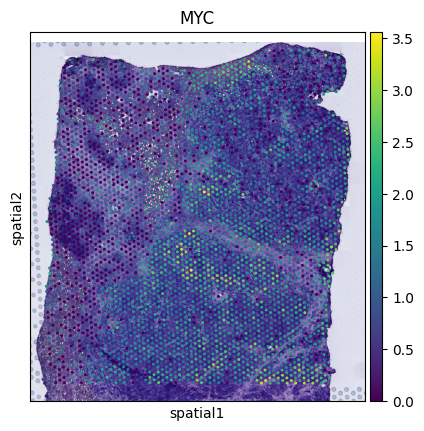

In [335]:
sc.pl.spatial(a, color=['MYC'])

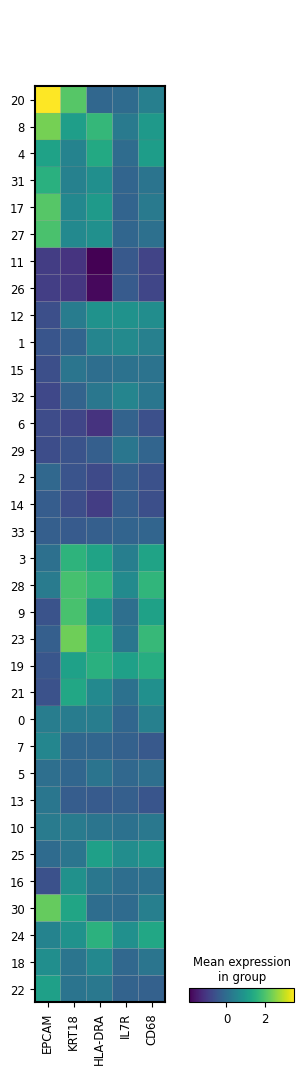

In [148]:
sc.pl.matrixplot(adata, var_names=['EPCAM', 'KRT18', 'HLA-DRA', 'IL7R', 'CD68'], groupby='cluster',
                 categories_order=[str(x) for x in dendrogram['leaves']])

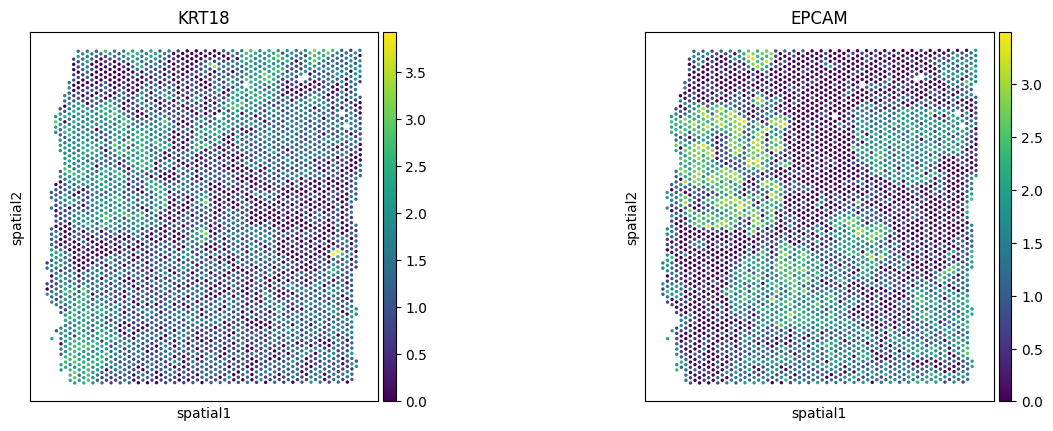

In [146]:
sc.pl.spatial(mushroom.learner.train_ds.section_to_adata['s0'], color=['KRT18', 'EPCAM'], alpha_img=0)

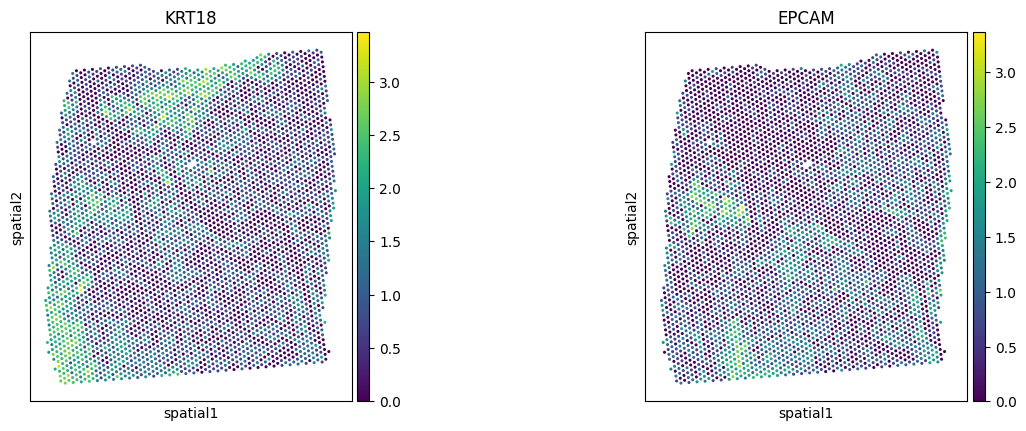

In [147]:
sc.pl.spatial(mushroom.learner.train_ds.section_to_adata['s1'], color=['KRT18', 'EPCAM'], alpha_img=0)

In [112]:
import anndata

In [117]:
adata = anndata.AnnData(X=rearrange(mushroom.recon_imgs, 'n c h w -> (n h w) c').numpy())
adata.var.index = mushroom.learner.channels
adata.obs['cluster'] = [str(x) for x in rearrange(cluster_ids, 'n h w -> (n h w)')]
adata

AnnData object with n_obs × n_vars = 18000 × 13417
    obs: 'cluster'

In [118]:
sc.tl.rank_genes_groups(adata, groupby='cluster', )

... storing 'cluster' as categorical
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarni

/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:411: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  self.stats[group_name, 'pvals_adj'] = pvals_adj[global_indices]
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: RuntimeWarning: invalid value encountered in log2
  self.stats[group_name, 'logfoldchanges'] = np.log2(
/data/estorrs/miniconda3/envs/mushroom/lib/python3.9/site-packages/scanpy/tools/_rank_genes_groups.py:422: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fra

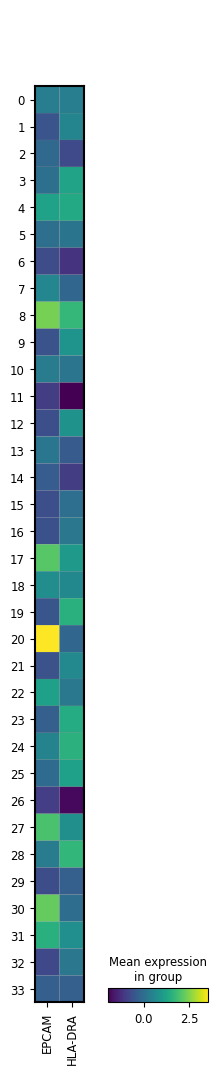

In [127]:
sc.pl.matrixplot(adata, var_names=['EPCAM', 'HLA-DRA'], groupby='cluster')

categories: 0, 1, 2, etc.
var_group_labels: 4, 31, 2, etc.


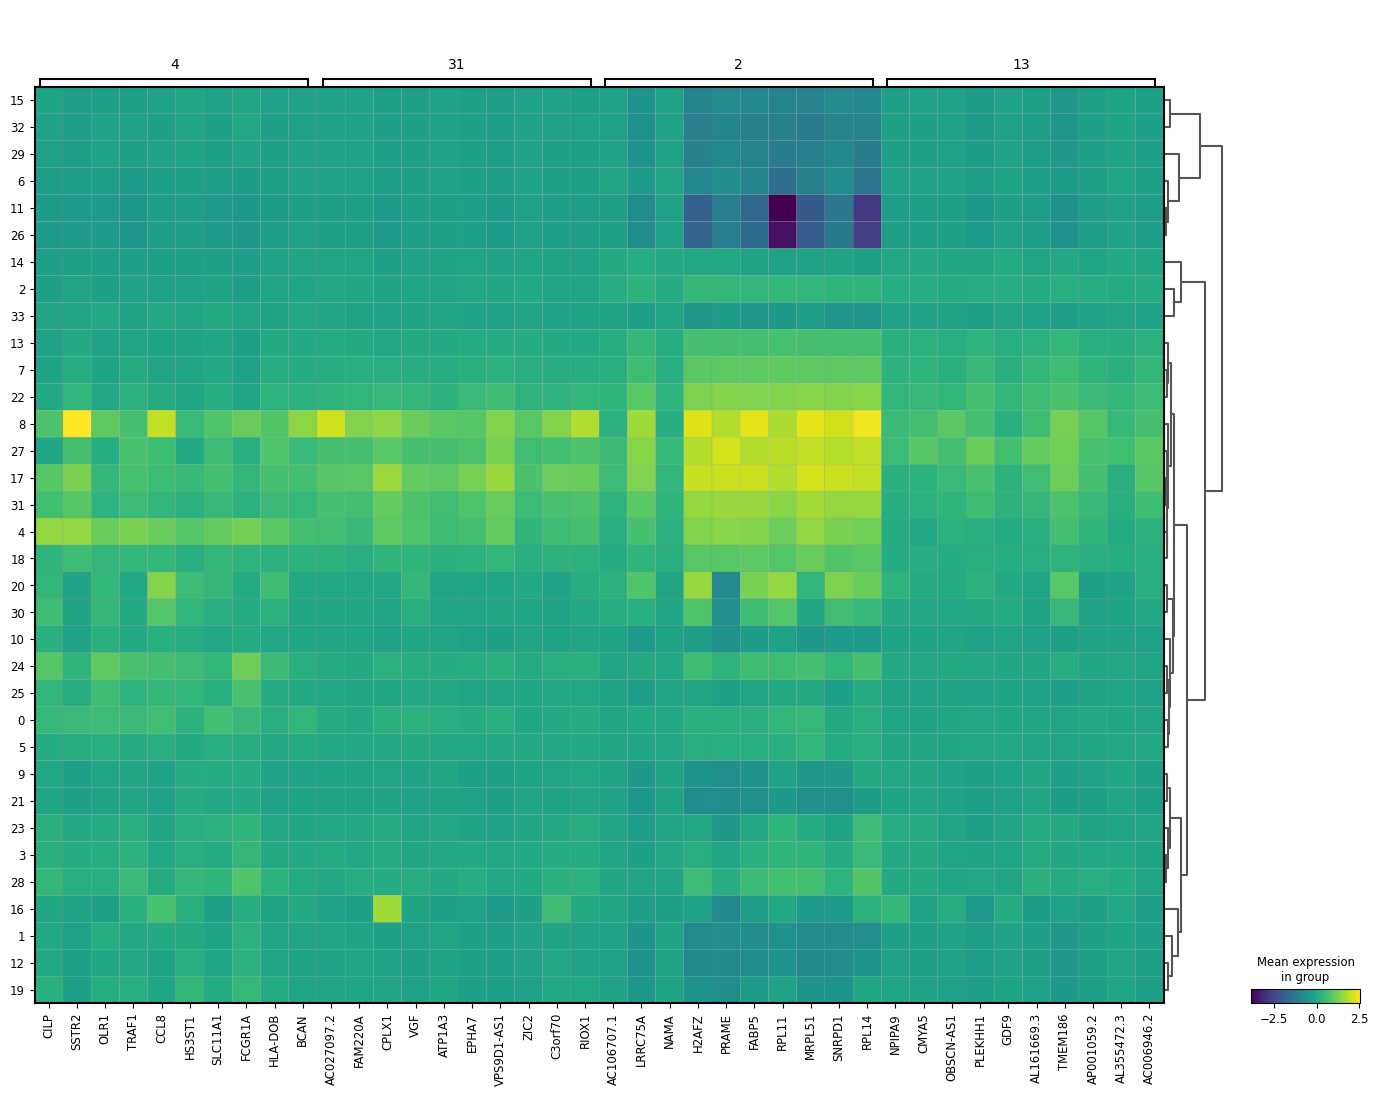

In [123]:
sc.pl.rank_genes_groups_matrixplot(adata, groups=['4', '31', '2', '13'])

In [24]:
exp = []
for i in range(cluster_ids.max() + 1):
    mask = cluster_ids == i
    x = rearrange(mushroom.recon_imgs, 'n d h w -> d n h w')
#     print(x[:, mask].shape)
    exp.append(x[:, mask].mean(-1))
exp = torch.stack(exp)
exp = pd.DataFrame(data=exp.numpy(), columns=mushroom.learner.channels)
exp = exp[~pd.isnull(exp.iloc[:, 0])]
exp


A1BG  A1BG-AS1      A1CF       A2M     A2ML1    A4GALT      AAAS  \
1  -0.160118  0.199095 -0.219669  0.205425  0.138341  0.242662  0.353163   
3  -0.167880 -0.036721 -0.179811  0.197898 -0.397196  0.089621 -0.186103   
8  -0.461804 -0.112335 -0.211343 -0.579283  0.084842 -0.143435 -0.174249   
12  1.923114  0.085878  1.672039  1.487268 -0.065837  0.128824  0.386476   
18  0.141422  0.503146 -0.140635  0.651180  0.724538  0.227245  0.785558   
19 -0.169223  0.003114 -0.151011 -0.108184 -0.006571 -0.036939 -0.037453   
20 -0.668673 -0.210937 -0.255446 -0.714747 -0.397274 -0.130596 -0.435490   
21 -0.182418  0.083418 -0.200906 -0.366580  0.522053 -0.111366  0.126082   
28  0.854204  0.443436  0.397093  0.886658  2.136480 -0.078143  1.372390   
29  2.663563 -0.077603  1.994539  1.773546 -0.391660  0.084251  0.197249   
30 -0.175788  0.062354 -0.167306  0.133358 -0.321234  0.099725  0.027086   
31 -0.894287 -0.275057 -0.294492 -0.989959 -0.555908 -0.183902 -0.582619   
39  0.382288 -0.016123 -0.006736  1.029112 -0.455466  0.437437 -0.120497   
40 -0.328906 -0.039336 -0.208100 -0.468288  0.300913 -0.135358 -0.046061   
42 -0.571017 -0.148507 -0.233043 -0.671396 -0.108838 -0.146702 -0.292401   
44  0.555991 -0.118531  0.093578  0.329980 -0.437408 -0.013126 -0.262657   
45  0.038303  0.013819 -0.153365  3.922721 -0.386162  2.831319  0.258879   
47  0.160599  0.577290 -0.204550  0.325563  1.691213 -0.031033  1.167786   
49  0.075082  0.229478 -0.074672  0.104560  0.411700  0.003400  0.340548   
53  1.203082 -0.038626  0.654791  1.558861 -0.429586  0.300799  0.069203   
57 -0.012679  0.537564 -0.201761  0.507285 -0.363255  0.148555  1.280926   
60  1.896960 -0.106078  1.074637  1.261422 -0.407776  0.087563 -0.009168   
66  0.007814  0.281477 -0.186099 -0.195985  1.035577 -0.073228  0.501764   
67  2.980199  0.173363  2.949493  2.220039 -0.293342  0.182043  0.477980   
79  0.605001  0.258977  0.297218  1.037830  0.092614  0.215618  0.424653   
87  0.071538  0.036632 -0.086887  0.599534 -0.183646  0.152572  0.042673   
88 -0.852744 -0.269097 -0.285564 -0.942069 -0.544640 -0.174383 -0.566993   
92  0.244475  0.558239 -0.231409  0.003989  1.928947 -0.021693  1.139147   
93  2.276659  0.322364  2.446991  1.904320  0.116647  0.263621  0.683497   
94 -0.404851 -0.143488 -0.210608 -0.319836 -0.444557 -0.035192 -0.352573   
95 -0.150586  0.413405 -0.254240  0.260766 -0.293907  0.099425  0.697898   
96  0.087124  0.409437 -0.145584  0.174116  1.206849 -0.022653  0.823016   
97  0.024336 -0.096597 -0.116695  0.224101 -0.497427  0.102123 -0.285955   
99 -0.389330 -0.075125 -0.205738 -0.368499 -0.241701 -0.056681 -0.209032   

        AACS     AADAC     AADAT  ...      ZUP1      ZW10    ZWILCH     ZWINT  \
1   0.210865 -0.277159  0.009619  ...  0.101173  0.176350  0.041306  0.006370   
3  -0.227192 -0.201515 -0.176492  ... -0.196023 -0.224913 -0.268145 -0.382874   
8  -0.072846 -0.296195 -0.066380  ... -0.074628 -0.107873 -0.043965  0.092270   
12  0.089963  1.989680  0.353798  ...  0.075155  0.223410  0.006360 -0.016305   
18  0.551302 -0.156978  0.336288  ...  0.665090  0.726086  0.745796  0.822033   
19 -0.024088 -0.213993 -0.052807  ... -0.015170  0.015920 -0.005926 -0.020422   
20 -0.339972 -0.347127 -0.234756  ... -0.313888 -0.353790 -0.339627 -0.389304   
21  0.215665 -0.246457  0.153186  ...  0.213982  0.213915  0.316159  0.469075   
28  0.616604  0.305207  1.050035  ...  2.019329  1.346491  1.845567  2.224607   
29 -0.072306  2.836567  0.293941  ... -0.133530 -0.052999 -0.229093 -0.335823   
30  0.035037 -0.232498 -0.031998  ... -0.088839 -0.073830 -0.052884 -0.183414   
31 -0.449063 -0.381402 -0.304465  ... -0.401037 -0.457823 -0.456977 -0.618018   
39 -0.151916  0.100671 -0.162687  ... -0.253456 -0.229883 -0.307557 -0.446070   
40  0.066646 -0.276540  0.032339  ...  0.049443  0.038383  0.142927  0.273987   
42 -0.209725 -0.319356 -0.138256  ... -0.175744 -0.230659 -0.190172 -0.095693   
44 -0.227986  0.187805 -0.152666  ... -0.238028 -0.

In [89]:
from sklearn.cluster import AgglomerativeClustering
dist = 30.
clustering = AgglomerativeClustering(n_clusters=None, distance_threshold=dist).fit(exp.values)
# clustering = AgglomerativeClustering(n_clusters=10, distance_threshold=None).fit(exp.values)
cluster_to_label = {c:l for c, l in zip(exp.index, clustering.labels_)}
neigh_ids = np.vectorize(cluster_to_label.get)(cluster_ids.numpy())
len(np.unique(neigh_ids))

19

In [90]:
clustering

AgglomerativeClustering(distance_threshold=30.0, n_clusters=None)

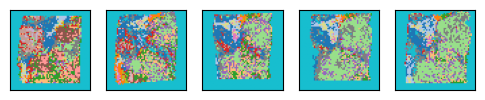

In [91]:
cmap = sns.color_palette('tab20') + sns.color_palette('tab20b') + sns.color_palette('tab20c')
cmap += cmap
cmap += cmap
fig, axs = plt.subplots(ncols=neigh_ids.shape[0], figsize=(6, 4))
for i, labeled in enumerate(neigh_ids):
    axs[i].imshow(display_labeled_as_rgb(labeled, cmap=cmap))
    axs[i].set_xticks([])
    axs[i].set_yticks([])

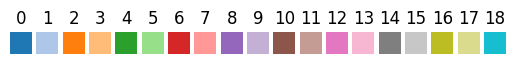

In [63]:
labels = np.unique(neigh_ids)
fig, axs = plt.subplots(ncols=len(labels))
for n, l in enumerate(labels):
    axs[n].imshow(rearrange(np.asarray(cmap[l]), 'n -> 1 1 n'))
    axs[n].axis('off')
    axs[n].set_title(str(l))
    

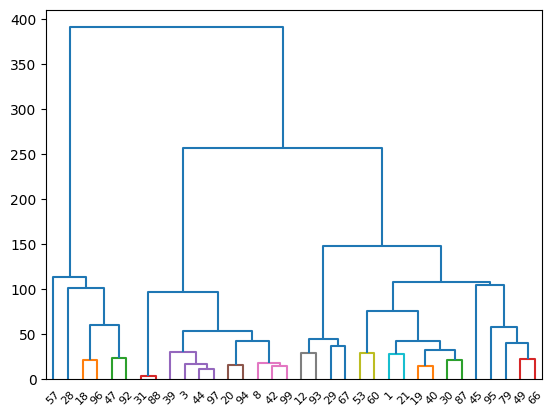

In [44]:
import scipy.cluster.hierarchy as shc
links = shc.linkage(exp.values, method ='ward')
dendrogram = shc.dendrogram((links), color_threshold=dist, labels=exp.index.to_list())

In [46]:
neigh_exp = []
for i in range(neigh_ids.max() + 1):
    mask = neigh_ids == i
    x = rearrange(mushroom.recon_imgs, 'n d h w -> d n h w')
    neigh_exp.append(x[:, mask].mean(-1))
neigh_exp = torch.stack(neigh_exp)
neigh_exp = pd.DataFrame(data=neigh_exp.numpy(), columns=mushroom.learner.channels)
neigh_exp


A1BG  A1BG-AS1      A1CF       A2M     A2ML1    A4GALT      AAAS  \
0   0.181148 -0.061152 -0.061499  0.486987 -0.450576  0.184164 -0.206921   
1   1.703763 -0.087297  0.957739  1.344239 -0.413848  0.146934  0.012653   
2   2.013268  0.146182  1.869651  1.593616 -0.019304  0.163197  0.462216   
3  -0.178022  0.106221 -0.204604 -0.253822  0.446413 -0.041577  0.170846   
4   0.040922  0.255885 -0.131257 -0.048064  0.728520 -0.035513  0.422417   
5  -0.502208 -0.123465 -0.220871 -0.587843 -0.064403 -0.130221 -0.237259   
6  -0.032211  0.047422 -0.120622  0.403981 -0.241362  0.130403  0.036135   
7   0.193777  0.569754 -0.215174  0.198363  1.785250 -0.027339  1.156458   
8  -0.265332 -0.022436 -0.185371 -0.324921  0.178495 -0.096175 -0.042634   
9  -0.012679  0.537564 -0.201761  0.507285 -0.363255  0.148555  1.280926   
10  0.097561  0.427449 -0.144632  0.265815  1.114142  0.025381  0.815816   
11 -0.150586  0.413405 -0.254240  0.260766 -0.293907  0.099425  0.697898   
12  2.980199  0.173363  2.949493  2.220039 -0.293342  0.182043  0.477980   
13  0.038303  0.013819 -0.153365  3.922721 -0.386162  2.831319  0.258879   
14 -0.531132 -0.175773 -0.232070 -0.508863 -0.421924 -0.080858 -0.392262   
15  0.854204  0.443436  0.397093  0.886658  2.136480 -0.078143  1.372390   
16  0.605001  0.258977  0.297218  1.037830  0.092614  0.215618  0.424653   
17  2.663563 -0.077603  1.994539  1.773546 -0.391660  0.084251  0.197249   
18 -0.892693 -0.274828 -0.294149 -0.988121 -0.555476 -0.183536 -0.582020   

        AACS     AADAC     AADAT  ...      ZUP1      ZW10    ZWILCH     ZWINT  \
0  -0.222991 -0.020429 -0.176369  ... -0.245296 -0.265320 -0.310326 -0.432136   
1  -0.110046  1.456658  0.046868  ... -0.140938 -0.133878 -0.244821 -0.358583   
2   0.106281  2.144154  0.380024  ...  0.111824  0.290631  0.028766  0.026286   
3   0.214719 -0.252509  0.124885  ...  0.191744  0.206510  0.261978  0.377863   
4   0.371625 -0.170111  0.247746  ...  0.416317  0.450790  0.491499  0.619593   
5  -0.158038 -0.305127 -0.116623  ... -0.141134 -0.180762 -0.141842 -0.057277   
6  -0.002370 -0.129277 -0.059618  ... -0.031752 -0.005228 -0.059860 -0.173898   
7   1.000643 -0.260757  0.616744  ...  1.036935  1.349995  1.245678  1.305956   
8   0.030522 -0.251639 -0.001560  ...  0.023719  0.029440  0.083664  0.156775   
9   1.560735 -0.333178  0.959744  ...  0.774836  1.195940  1.571359  1.465000   
10  0.598789 -0.174855  0.401773  ...  0.705731  0.866887  0.888105  0.974593   
11  0.861422 -0.344876  0.367306  ...  0.291413  0.475083  0.785840  0.590672   
12 -0.001830  3.675588  0.585093  ...  0.114971  0.173156 -0.080837 -0.180409   
13 -0.136709 -0.046142 -0.139716  ...  0.023805  0.080161 -0.220624 -0.257415   
14 -0.325399 -0.319058 -0.231471  ... -0.300532 -0.342418 -0.337444 -0.419354   
15  0.616604  0.305207  1.050035  ...  2.019329  1.346491  1.845567  2.224607   
16  0.289004  0.346523  0.129479  ...  0.245741  0.298005  0.210502  0.201306   
17 -0.072306  2.836567  0.293941  ... -0.133530 -0.052999 -0.229093 -0.335823   
18 -0.448644 -0.380917 -0.304206  ... -0.400700 -0.457470 -0.456435 -0.617415   

        ZXDB      ZXDC    ZYG11A    ZYG11B       ZYX     ZZEF1  
0  -0.114811 -0.260501 -0.157891 -0.086947  0.037748 -0.078495  
1   0.029508 -0.117224 -0.126133  0.062592  0.390369  0.065582  
2   0.379056  0.192163  0.062428  0.458858  0.810156  0.355504  
3   0.047844  0.241484  0.113960  0.013831  0.167443  0.082613  
4   0.193614  0.425621  0.235620  0.208226  0.546697  0.248774  
5  -0.130883 -0.151274 -0.062444 -0.194230 -0.488465 -0.179213  
6  -0.001993 -0.061061 -0.012270  0.101841  0.254512  0.060898  
7   0.627099  1.143468  0.522662  0.731781  1.347863  0.740154  
8  -0.042926  0.050721  0.028190 -0.060123 -0.111506 -0.031785  
9   0.568527  0.568773  1.265653  1.040708  0.558424  0.726919  
10  0.386227  0.751563  0.367272  0.463120  1.096311  0.500027  
11  0.333082  0.276360  0.342945  0.433202  0.317070  0.302573  
12  0.517044  0.24051

In [47]:
mushroom.recon_imgs.shape

torch.Size([5, 13417, 60, 60])

In [55]:
# calculate distances
x = rearrange(mushroom.recon_imgs, 'n d h w -> n h w d')
y = torch.tensor(neigh_exp.values)
dists = torch.cdist(x, y)
dists.shape

torch.Size([5, 60, 60, 19])

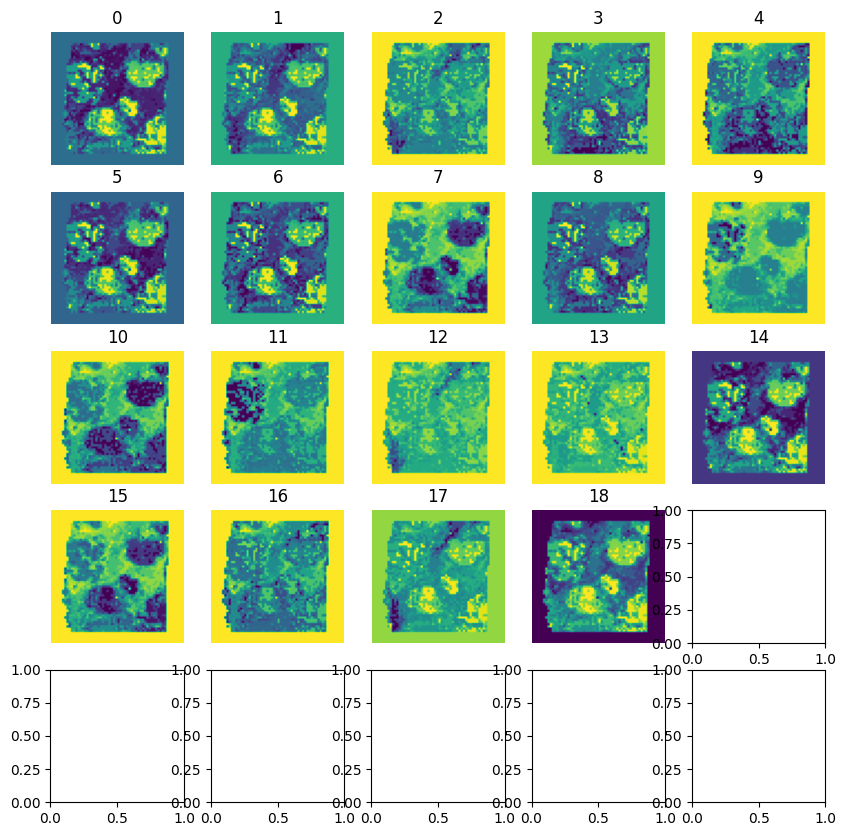

In [56]:
fig, axs = plt.subplots(nrows=5, ncols=5, figsize=(10, 10))
for i in range(dists.shape[-1]):
    r = i // 5
    c = i % 5
    
    ax = axs[r, c]
    ax.imshow(dists[0, :, :, i])
    ax.axis('off')
    ax.set_title(i)

In [92]:
np.save('/data/estorrs/sandbox/HT268B1_test.npy', neigh_ids)

In [121]:
def show_gene(gene, cut):
    clusters = exp[exp[gene] > cut].index.to_list()
    print(clusters)
    mask = torch.stack([cluster_ids == c for c in clusters])
    mask = mask.sum(0) > 0
    plt.imshow(mask[0])

[23, 35, 40, 41, 96]


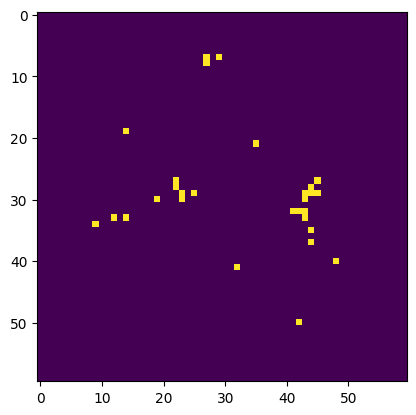

In [126]:
show_gene('CD68', .9)

In [48]:
mushroom.recon_imgs[..., mask].shape

torch.Size([2, 11622, 15])

In [41]:
mushroom.recon_imgs.shape

torch.Size([2, 11622, 60, 60])

## calculate codebook distances

In [115]:
case_mapping = {}

In [35]:
mushroom_config = {
    'dtype': 'visium',
#     'sections': config,
    'chkpt_filepath': None,
    'sae_kwargs': {
        'size': 256,
        'patch_size': 32,
        'triplet_scaler': .1,
        'recon_scaler': 1.,
    },
    'learner_kwargs': {
        'scale': .1,
        'pct_expression': .02,
        'batch_size': 32,
        'num_workers': 1,
        'device': 'cuda:3'
#         'channels': channels,
#         'channel_mapping': channel_mapping
    },
    'train_kwargs': {
        'num_iters': 2000,
        'lr': 1e-4,
        'log_every': 10,
        'save_every': 500,
#         'save_dir': chkpt_dir       
    },
    'cluster_kwargs': {
        'num_clusters': 20,
        'mask_background': True,
        'margin': .05,
        'background_channels': None,
        'span_all_sections': True,
        'centroids': None,
    }
}

In [42]:
# config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT268B1/config.yaml'
# config_fp = '/data/estorrs/mushroom/data/projects/subclone/mushroom/HT397B1/config.yaml'
config_fp = '/data/estorrs/mushroom/data/examples/HT397B1_v1/registration/registered/mushroom_inputs.yaml'

config = yaml.safe_load(open(config_fp))
case = config_fp.split('/')[-2]

out_dir = '/data/estorrs/mushroom/data/examples/HT397B1_v1/mushroom_outputs/visium_v2'
chkpt_filepath = os.path.join(out_dir, 'chkpts', '600iter.pt')

# out_dir = os.path.join(f'/data/estorrs/mushroom/data/projects/subclone/mushroom/{case}_novq/outputs')
# chkpt_filepath = f'/data/estorrs/mushroom/data/projects/subclone/mushroom/{case}_novq/outputs/chkpts/400iter.pt'

In [43]:
mushroom_config['sections'] = config
# mushroom_config['train_kwargs']['save_dir'] = chkpt_dir
mushroom_config['chkpt_filepath'] = chkpt_filepath

In [44]:
mushroom = Mushroom.from_config(mushroom_config)

INFO:root:using device: cuda:3
INFO:root:generating inputs for visium tissue sections
INFO:root:using 11608 channels
INFO:root:2 sections detected: ['s0', 's3']
INFO:root:processing sections
/data/estorrs/mushroom/mushroom/data/visium.py:54: RuntimeWarning: invalid value encountered in divide
  adata.X = adata.X / adata.X.max(0)
/data/estorrs/mushroom/mushroom/data/visium.py:54: RuntimeWarning: invalid value encountered in divide
  adata.X = adata.X / adata.X.max(0)
INFO:root:generating training dataset
INFO:root:generating inference dataset
INFO:root:creating data loaders
INFO:root:creating ViT
INFO:root:learner initialized
INFO:root:initializing clusterer
INFO:root:no background channel detected, defaulting to mean of all channels


In [45]:
mushroom.embed_sections()

In [30]:
# dists = torch.cdist(rearrange(mushroom.recon_embs_prequant, 'n d h w -> n h w d'),
#                     mushroom.learner.sae.vq.codebook.clone().cpu())
# dists.shape

In [16]:
torch.save(dists, os.path.join(out_dir, 'distances.pt'))

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

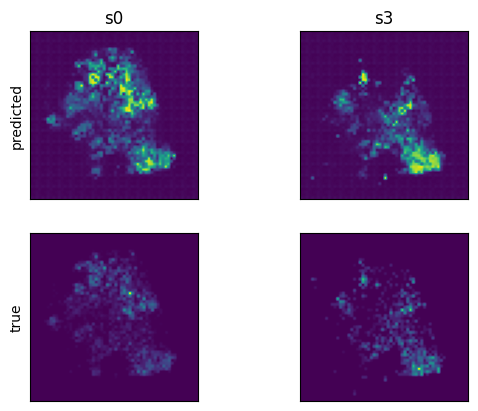

In [46]:
mushroom.display_predicted_pixels(channel='EPCAM')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

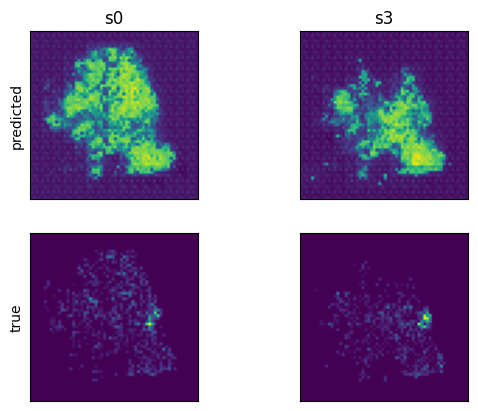

In [47]:
mushroom.display_predicted_pixels(channel='CD68')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

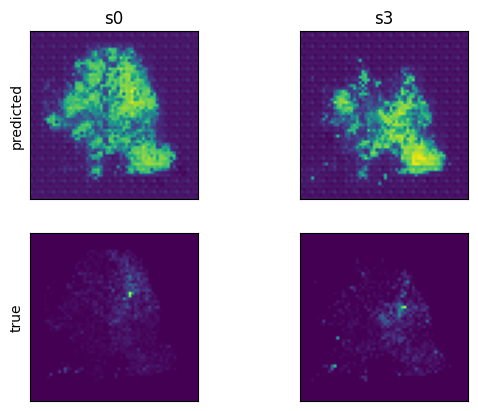

In [48]:
mushroom.display_predicted_pixels(channel='ACTA2')

array([[<Axes: title={'center': 's0'}, ylabel='predicted'>,
        <Axes: title={'center': 's3'}>],
       [<Axes: ylabel='true'>, <Axes: >]], dtype=object)

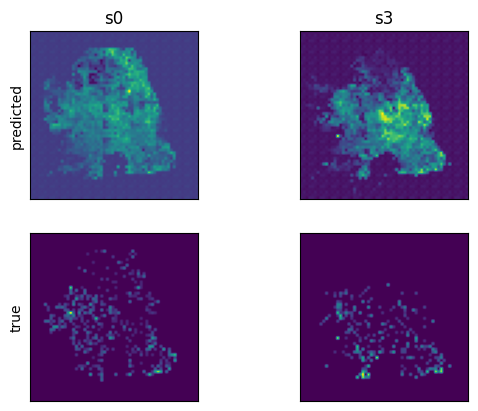

In [153]:
mushroom.display_predicted_pixels(channel='IL7R')

In [142]:
mushroom.cluster_sections(margin=.1)

INFO:root:no background channel detected, defaulting to mean of all channels


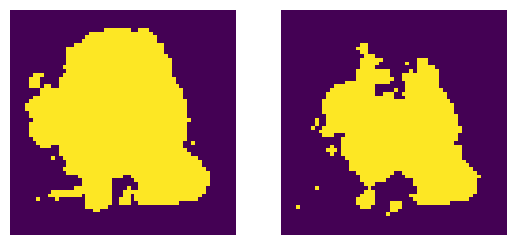

In [143]:
mushroom.clusterer.display_section_masks()

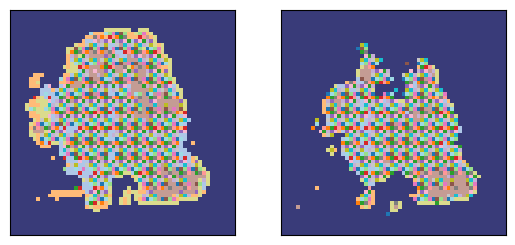

In [144]:
mushroom.clusterer.display_cluster_ids(mushroom.cluster_ids)

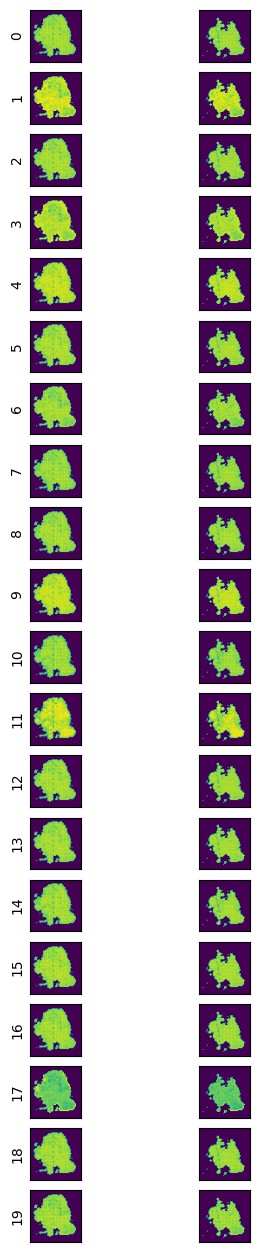

In [145]:
mushroom.clusterer.display_distances(mushroom.dists, figsize=(4, 16))

## integrate rctd

In [6]:
# df = pd.read_csv(
#     '/diskmnt/Datasets/Spatial_Transcriptomics/Analysis/ST_subclone/13-RCTD/13_3-cohort/Sample_ref/RCTD_all_celltype_cohort_2023-09-19.tsv',
    
# )

rctd_df = pd.read_csv(
    '/data/estorrs/sandbox/RCTD_all_celltype_cohort_2023-09-19.tsv',
    sep='\t'
    
)
rctd_df = rctd_df[[c for c in rctd_df.columns if 'RCTD' == c[:4] or c in ['sample_id', 'barcode']]]
rctd_df

sample_id             barcode  RCTD_Tumor  RCTD_B  \
0           HT112C1-U1_ST_Bn1  AAACAAGTATCTCCCA-1    0.949060     0.0   
1           HT112C1-U1_ST_Bn1  AAACACCAATAACTGC-1    0.969906     0.0   
2           HT112C1-U1_ST_Bn1  AAACATTTCCCGGATT-1    0.751848     0.0   
3           HT112C1-U1_ST_Bn1  AAACCCGAACGAAATC-1    0.000000     0.0   
4           HT112C1-U1_ST_Bn1  AAACCGGGTAGGTACC-1    0.922255     0.0   
...                       ...                 ...         ...     ...   
120123  HT472C1-Th1K1Fp1U1Bp1  TTGTTAGCAAATTCGA-1    0.000000     0.0   
120124  HT472C1-Th1K1Fp1U1Bp1  TTGTTCAGTGTGCTAC-1    0.000000     0.0   
120125  HT472C1-Th1K1Fp1U1Bp1  TTGTTGTGTGTCAAGA-1    1.000000     0.0   
120126  HT472C1-Th1K1Fp1U1Bp1  TTGTTTCATTAGTCTA-1    1.000000     0.0   
120127  HT472C1-Th1K1Fp1U1Bp1  TTGTTTCCATACAACT-1    0.000000     0.0   

        RCTD_Endothelial  RCTD_Fibroblast  RCTD_Hepatocyte  RCTD_Macrophage  \
0                    0.0         0.000000         0.000000         0.050940   
1                    0.0         0.030094         0.000000         0.000000   
2                    0.0         0.113756         0.000000         0.134396   
3                    0.0         0.230694         0.127608         0.326089   
4                    0.0         0.020764         0.000000         0.056981   
...                  ...              ...              ...              ...   
120123               0.0         0.000000         0.000000         1.000000   
120124               0.0         0.000000         0.000000         0.000000   
120125               0.0         0.000000         0.000000         0.000000   
120126               0.0         0.000000         0.000000         0.000000   
120127               0.0         0.000000         0.000000         0.000000   

        RCTD_NK  RCTD_Plasma  ...  RCTD_Pericyte  RCTD_Cholangiocyte  \
0           0.0          0.0  ...            NaN                 NaN   
1           0.0          0.0  ...            NaN                 NaN   
2           0.0          0.0  ...            NaN                 NaN   
3           0.0          0.0  ...            NaN                 NaN   
4           0.0          0.0  ...            NaN                 NaN   
...         ...          ...  ...            ...                 ...   
120123      NaN          NaN  ...            NaN                 0.0   
120124      NaN          NaN  ...            NaN                 0.0   
120125      NaN          NaN  ...            NaN                 0.0   
120126      NaN          NaN  ...            NaN                 0.0   
120127      NaN          NaN  ...            NaN                 0.0   

        RCTD_cDC2  RCTD_Ductal  RCTD_Islet_alpha  RCTD_Islet_beta  \
0             NaN          NaN               NaN              NaN   
1             NaN          NaN               NaN              NaN   
2             NaN          NaN               NaN              NaN   
3             NaN          NaN               NaN              NaN   
4             NaN          NaN               NaN              NaN   
...           ...          ...               ...              ...   
120123        NaN          NaN               NaN              NaN   
120124        NaN          NaN               NaN              NaN   
120125        NaN          NaN               NaN              NaN   
120126        NaN          NaN               NaN              NaN   
120127        NaN          NaN               NaN              NaN   

        RCTD_Islet_gamma  RCTD_Acinar  RCTD_Islet  RCTD_Lymphatic  
0                    NaN          NaN         NaN             NaN  
1                    NaN          NaN         NaN             NaN  
2                    NaN          NaN         NaN             NaN  
3                    NaN          NaN         NaN             NaN  
4                    NaN          NaN         NaN             NaN  
...                  ...          ...         ...             ...  
120123               NaN

In [7]:
sorted(set(rctd_df['sample_id']))

['HT112C1-U1_ST_Bn1',
 'HT112C1-U2_ST_Bn1',
 'HT206B1-S1Fc1U2Z1B1',
 'HT206B1-S1Fc1U3Z1B1',
 'HT206B1-S1Fc1U4Z1B1',
 'HT206B1-S1Fc1U5Z1B1',
 'HT206B1-U1_ST_Bn1',
 'HT253C1-Th1K1Fc2U1Z1Bs1',
 'HT260C1-Th1K1Fc2U1Z1Bs1',
 'HT265B1-S1H1Fc2U1Z1Bs1',
 'HT268B1-Th1H3Fc2U12Z1Bs1',
 'HT268B1-Th1H3Fc2U22Z1Bs1',
 'HT268B1-Th1H3Fc2U2Z1Bs1',
 'HT268B1-Th1H3Fc2U32Z1Bs1',
 'HT268B1-Th1K3Fc2U1Z1Bs1',
 'HT270P1-H2Fc2U1Z1Bs1',
 'HT270P1-S1H1Fs5U1Bp1',
 'HT288P1-S1H4Fc2U1Z1Bs1',
 'HT306P1-S1H1Fc2U1Z1Bs1',
 'HT308B1-S1H1Fc2U1Z1Bs1',
 'HT308B1-S1H4Fc2U1Z1Bs1',
 'HT308B1-S1H5Fc2U1Z1Bs1',
 'HT308B1-S2H5Fc2U1Z1Bs1',
 'HT339B1-S1H3Fc2U1Z1Bs1',
 'HT339B1-S1H3Fc2U2Bs2',
 'HT339B2-H1Fp1U1Bp1',
 'HT397B1-S1H2Fs4U1Bp1',
 'HT397B1-S1H3A1U1Bp1',
 'HT397B1-S1H3A1U21Bp1',
 'HT397B1-S1H3Fs1U1Bp1',
 'HT472C1-S1H4Fp1U1Bp1',
 'HT472C1-Th1K1Fp1U1Bp1']

In [8]:
mapping = {
    'HT206B1-U2': 'HT206B1-S1Fc1U2Z1B1',
    'HT206B1-U3': 'HT206B1-S1Fc1U3Z1B1',
    'HT206B1-U4': 'HT206B1-S1Fc1U4Z1B1',
    'HT206B1-U5': 'HT206B1-S1Fc1U5Z1B1',
    'HT268B1-U1': 'HT268B1-Th1K3Fc2U1Z1Bs1',
    'HT268B1-U2': 'HT268B1-Th1H3Fc2U2Z1Bs1',
    'HT268B1-U12': 'HT268B1-Th1H3Fc2U12Z1Bs1',
    'HT268B1-U22': 'HT268B1-Th1H3Fc2U22Z1Bs1',
    'HT268B1-U32': 'HT268B1-Th1H3Fc2U32Z1Bs1',
    'HT397B1-U1': 'HT397B1-S1H3A1U1Bp1',
    'HT397B1-U21': 'HT397B1-S1H3A1U21Bp1',
}
r_mapping = {v:k for k, v in mapping.items()}

In [9]:
for x in sorted(set(rctd_df['sample_id'])):
    if x in r_mapping:
        print(x)

HT206B1-S1Fc1U2Z1B1
HT206B1-S1Fc1U3Z1B1
HT206B1-S1Fc1U4Z1B1
HT206B1-S1Fc1U5Z1B1
HT268B1-Th1H3Fc2U12Z1Bs1
HT268B1-Th1H3Fc2U22Z1Bs1
HT268B1-Th1H3Fc2U2Z1Bs1
HT268B1-Th1H3Fc2U32Z1Bs1
HT268B1-Th1K3Fc2U1Z1Bs1
HT397B1-S1H3A1U1Bp1
HT397B1-S1H3A1U21Bp1


In [10]:
rctd_df['spot_id'] = [f'{r_mapping[sample]}_{barcode}' if sample in r_mapping else None
                 for sample, barcode in zip(rctd_df['sample_id'], rctd_df['barcode'])]
rctd_df = rctd_df[~pd.isnull(rctd_df['spot_id'])]
rctd_df = rctd_df.set_index('spot_id')
rctd_df

sample_id             barcode  \
spot_id                                                                    
HT206B1-U2_AAACAACGAATAGTTC-1    HT206B1-S1Fc1U2Z1B1  AAACAACGAATAGTTC-1   
HT206B1-U2_AAACAAGTATCTCCCA-1    HT206B1-S1Fc1U2Z1B1  AAACAAGTATCTCCCA-1   
HT206B1-U2_AAACAATCTACTAGCA-1    HT206B1-S1Fc1U2Z1B1  AAACAATCTACTAGCA-1   
HT206B1-U2_AAACACCAATAACTGC-1    HT206B1-S1Fc1U2Z1B1  AAACACCAATAACTGC-1   
HT206B1-U2_AAACAGAGCGACTCCT-1    HT206B1-S1Fc1U2Z1B1  AAACAGAGCGACTCCT-1   
...                                              ...                 ...   
HT397B1-U21_TTGTTCAGTGTGCTAC-1  HT397B1-S1H3A1U21Bp1  TTGTTCAGTGTGCTAC-1   
HT397B1-U21_TTGTTGTGTGTCAAGA-1  HT397B1-S1H3A1U21Bp1  TTGTTGTGTGTCAAGA-1   
HT397B1-U21_TTGTTTCACATCCAGG-1  HT397B1-S1H3A1U21Bp1  TTGTTTCACATCCAGG-1   
HT397B1-U21_TTGTTTCATTAGTCTA-1  HT397B1-S1H3A1U21Bp1  TTGTTTCATTAGTCTA-1   
HT397B1-U21_TTGTTTGTATTACACG-1  HT397B1-S1H3A1U21Bp1  TTGTTTGTATTACACG-1   

                                RCTD_Tumor  RCTD_B  RCTD_Endothelial  \
spot_id                                                                
HT206B1-U2_AAACAACGAATAGTTC-1     0.867253     0.0          0.132747   
HT206B1-U2_AAACAAGTATCTCCCA-1     0.891083     0.0          0.108917   
HT206B1-U2_AAACAATCTACTAGCA-1     0.666476     0.0          0.000000   
HT206B1-U2_AAACACCAATAACTGC-1     0.618238     0.0          0.000000   
HT206B1-U2_AAACAGAGCGACTCCT-1     0.619450     0.0          0.099943   
...                                    ...     ...               ...   
HT397B1-U21_TTGTTCAGTGTGCTAC-1    0.419446     0.0          0.000000   
HT397B1-U21_TTGTTGTGTGTCAAGA-1    0.000000     0.0          0.000000   
HT397B1-U21_TTGTTTCACATCCAGG-1    0.894991     0.0          0.000000   
HT397B1-U21_TTGTTTCATTAGTCTA-1    0.000000     0.0          0.000000   
HT397B1-U21_TTGTTTGTATTACACG-1    0.000000     0.0          0.000000   

                                RCTD_Fibroblast  RCTD_Hepatocyte  \
spot_id                                                            
HT206B1-U2_AAACAACGAATAGTTC-1          0.000000              NaN   
HT206B1-U2_AAACAAGTATCTCCCA-1          0.000000              NaN   
HT206B1-U2_AAACAATCTACTAGCA-1          0.109011              NaN   
HT206B1-U2_AAACACCAATAACTGC-1          0.000000              NaN   
HT206B1-U2_AAACAGAGCGACTCCT-1          0.109454              NaN   
...                                         ...              ...   
HT397B1-U21_TTGTTCAGTGTGCTAC-1         0.498006              NaN   
HT397B1-U21_TTGTTGTGTGTCAAGA-1         0.546774              NaN   
HT397B1-U21_TTGTTTCACATCCAGG-1         0.105009              NaN   
HT397B1-U21_TTGTTTCATTAGTCTA-1         1.000000              NaN   
HT397B1-U21_TTGTTTGTATTACACG-1         1.000000              NaN   

                                RCTD_Macrophage  RCTD_NK  RCTD_Plasma  ...  \
spot_id                                                                ...   
HT206B1-U2_AAACAACGAATAGTTC-1          0.000000      0.0     0.000000  ...   
HT206B1-U2_AAACAAGTATCTCCCA-1          0.000000      0.0     0.000000  ...   
HT206B1-U2_AAACAATCTACTAGCA-1          0.131314      0.0     0.093199  ...   
HT206B1-U2_AAACACCAATAACTGC-1          0.000000      0.0     0.000000  ...   
HT206B1-U2_AAACAGAGCGACTCCT-1          0.171153      0.0     0.000000  ...   
...                                         ...      ...          ...  ...   
HT397B1-U21_TTGTTCAGTGTGCTAC-1         0.000000      NaN     0.082547  ...   
HT397B1-U21_TTGTTGTGTGTCAAGA-1         0.315271      NaN     0.137954  ...   
HT397B1-U21_TTGTTTCACATCCAGG-1         0.000000      NaN     0.000000  ...   
HT397B1-U21_TTGTTTCATTAGTCTA-1         0.000000      NaN     0.000000  ...   
HT397B1-U21_TTGTTTGTATTACACG-1         0.000000      NaN     0.000000  ...   

                                RCTD_Pericyte  RCTD_Cholangiocyte  RCTD_cDC2  \
spot_id                                                                        
HT206B1-U2_AAACAACGAATAGTTC-1             0.0            

In [11]:
list(rctd_df.columns)

['sample_id',
 'barcode',
 'RCTD_Tumor',
 'RCTD_B',
 'RCTD_Endothelial',
 'RCTD_Fibroblast',
 'RCTD_Hepatocyte',
 'RCTD_Macrophage',
 'RCTD_NK',
 'RCTD_Plasma',
 'RCTD_T',
 'RCTD_T_reg',
 'RCTD_Basal',
 'RCTD_cDC1',
 'RCTD_LumHR',
 'RCTD_LumSec',
 'RCTD_Mast',
 'RCTD_mregDC',
 'RCTD_pDC',
 'RCTD_Pericyte',
 'RCTD_Cholangiocyte',
 'RCTD_cDC2',
 'RCTD_Ductal',
 'RCTD_Islet_alpha',
 'RCTD_Islet_beta',
 'RCTD_Islet_gamma',
 'RCTD_Acinar',
 'RCTD_Islet',
 'RCTD_Lymphatic']

In [12]:
## roll in

In [13]:
case = 'HT397B1'

In [14]:
# dists = torch.load(f'/data/estorrs/mushroom/data/projects/subclone/mushroom/{case}/outputs/distances.pt')
# dists.shape

In [140]:
config = yaml.safe_load(open(f'/data/estorrs/mushroom/data/projects/subclone/mushroom/{case}/config.yaml'))
config


[{'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium.h5ad'},
   {'dtype': 'visium',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.h5ad'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s1_multiplex.ome.tiff'}],
  'id': 's1',
  'position': 5},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s2_multiplex.ome.tiff'}],
  'id': 's2',
  'position': 55},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium.h5ad'},
   {'dtype': 'visium',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.h5ad'}],
  'id': 's3',
  'position': 100},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorr

In [147]:
sid_to_adata = {}
for data in config:
    for entry in data['data']:
        if entry['dtype'] == 'visium':
            adata = sc.read_h5ad(entry['filepath'])
            adata.obs = pd.merge(adata.obs, rctd_df, left_index=True, right_index=True)
            sid_to_adata[data['id']] = adata

In [148]:
sid_to_adata['s0'].obs

in_tissue  array_row  array_col  FC1    FC2  \
HT397B1-U1_AAACAAGTATCTCCCA-1          1         50        102  0.0    0.0   
HT397B1-U1_AAACACCAATAACTGC-1          1         59         19  1.0  232.0   
HT397B1-U1_AAACAGAGCGACTCCT-1          1         14         94  0.0    0.0   
HT397B1-U1_AAACAGCTTTCAGAAG-1          1         43          9  0.0    0.0   
HT397B1-U1_AAACAGGGTCTATATT-1          1         47         13  1.0  232.0   
...                                  ...        ...        ...  ...    ...   
HT397B1-U1_TTGTTCAGTGTGCTAC-1          1         24         64  0.0    0.0   
HT397B1-U1_TTGTTGTGTGTCAAGA-1          1         31         77  0.0    0.0   
HT397B1-U1_TTGTTTCACATCCAGG-1          1         58         42  0.0    0.0   
HT397B1-U1_TTGTTTCCATACAACT-1          1         45         27  0.0    0.0   
HT397B1-U1_TTGTTTGTATTACACG-1          1         73         41  0.0    0.0   

                               FC3    FC4      FC5    FC6  \
HT397B1-U1_AAACAAGTATCTCCCA-1  0.0    0.0      0.0    0.0   
HT397B1-U1_AAACACCAATAACTGC-1  1.0  232.0      1.0  232.0   
HT397B1-U1_AAACAGAGCGACTCCT-1  0.0    0.0      0.0    0.0   
HT397B1-U1_AAACAGCTTTCAGAAG-1  0.0    0.0      0.0    0.0   
HT397B1-U1_AAACAGGGTCTATATT-1  0.0    0.0  unknown    0.0   
...                            ...    ...      ...    ...   
HT397B1-U1_TTGTTCAGTGTGCTAC-1  0.0    0.0      0.0    0.0   
HT397B1-U1_TTGTTGTGTGTCAAGA-1  0.0    0.0      0.0    0.0   
HT397B1-U1_TTGTTTCACATCCAGG-1  0.0    0.0      0.0    0.0   
HT397B1-U1_TTGTTTCCATACAACT-1  0.0    0.0      0.0    0.0   
HT397B1-U1_TTGTTTGTATTACACG-1  0.0    0.0      0.0    0.0   

                               Filtered tumor regions  ...  RCTD_Pericyte  \
HT397B1-U1_AAACAAGTATCTCCCA-1                     0.0  ...            NaN   
HT397B1-U1_AAACACCAATAACTGC-1                    33.0  ...            NaN   
HT397B1-U1_AAACAGAGCGACTCCT-1                     0.0  ...            NaN   
HT397B1-U1_AAACAGCTTTCAGAAG-1                     0.0  ...            NaN   
HT397B1-U1_AAACAGGGTCTATATT-1                     1.0  ...            NaN   
...                                               ...  ...            ...   
HT397B1-U1_TTGTTCAGTGTGCTAC-1                     0.0  ...            NaN   
HT397B1-U1_TTGTTGTGTGTCAAGA-1                     0.0  ...            NaN   
HT397B1-U1_TTGTTTCACATCCAGG-1                     0.0  ...            NaN   
HT397B1-U1_TTGTTTCCATACAACT-1                     0.0  ...            NaN   
HT397B1-U1_TTGTTTGTATTACACG-1                     0.0  ...            NaN   

                              RCTD_Cholangiocyte  RCTD_cDC2  RCTD_Ductal  \
HT397B1-U1_AAACAAGTATCTCCCA-1                NaN        NaN          NaN   
HT397B1-U1_AAACACCAATAACTGC-1                NaN        NaN          NaN   
HT397B1-U1_AAACAGAGCGACTCCT-1                NaN        NaN          NaN   
HT397B1-U1_AAACAGCTTTCAGAAG-1                NaN        NaN          NaN   
HT397B1-U1_AAACAGGGTCTATATT-1                NaN        NaN          NaN   
...                                          ...        ...          ...   
HT397B1-U1_TTGTTCAGTGTGCTAC-1                NaN        NaN          NaN   
HT397B1-U1_TTGTTGTGTGTCAAGA-1                NaN        NaN          NaN   
HT397B1-U1_TTGTTTCACATCCAGG-1                NaN        NaN          NaN   
HT397B1-U1_TTGTTTCCATACAACT-1                NaN        NaN          NaN   
HT397B1-U1_TTGTTTGTATTACACG-1                NaN        NaN          NaN   

                               RCTD_Islet_alpha RCTD_Islet_beta  \
HT397B1-U1_AAACAAGTATCTCCCA-1               NaN             NaN   
HT397B1-U1_AAACACCAATAACTGC-1               NaN             NaN   
HT397B1-U1_AAACAGAGCGACTCCT-1               NaN             NaN   
HT397B1-U1_AAACAGCTTTCAGAAG-1               NaN             NaN   
HT397B1-U1_AAACAGGGTCTATATT-1               NaN             NaN   
...                                         ...             ...   
HT397B1-U1_TTGTTCAGTGTGCTAC-1               NaN       

In [149]:
adata = next(iter(sid_to_adata.values()))
# sc.pp.normalize_total(adata)
# sc.pp.log1p(adata)
# sc.pp.scale(adata)
adata

AnnData object with n_obs × n_vars = 3058 × 17943
    obs: 'in_tissue', 'array_row', 'array_col', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'Filtered tumor regions', 'Filtered tumor regions auto', 'Filtered tumor vs. TME', 'Manual annotation', 'Morphologically processed purity', 'Purity', 'TME before boundary', 'TME boundary', 'Tumor before boundary', 'Tumor boundary', 'Tumor regions', 'Tumor vs. TME', 'barcode_x', 'library_id', 'original', 'sample_id_x', 'subclone', 'sample_id_y', 'barcode_y', 'RCTD_Tumor', 'RCTD_B', 'RCTD_Endothelial', 'RCTD_Fibroblast', 'RCTD_Hepatocyte', 'RCTD_Macrophage', 'RCTD_NK', 'RCTD_Plasma', 'RCTD_T', 'RCTD_T_reg', 'RCTD_Basal', 'RCTD_cDC1', 'RCTD_LumHR', 'RCTD_LumSec', 'RCTD_Mast', 'RCTD_mregDC', 'RCTD_pDC', 'RCTD_Pericyte', 'RCTD_Cholangiocyte', 'RCTD_cDC2', 'RCTD_Ductal', 'RCTD_Islet_alpha', 'RCTD_Islet_beta', 'RCTD_Islet_gamma', 'RCTD_Acinar', 'RCTD_Islet', 'RCTD_Lymphatic'
    var: 'gene_ids', 'feature_types', 'genome'
    uns: 'spatial'
    obsm: 'spat

... storing 'sample_id_y' as categorical


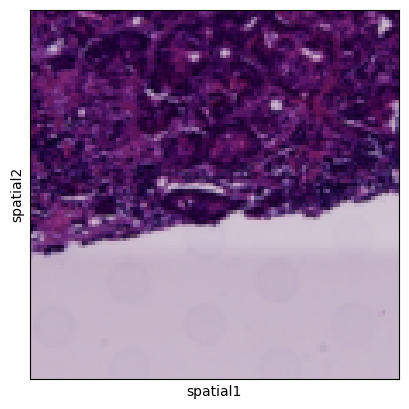

In [150]:
bbox1 = (12500, 15500, 11000, 14000)
bbox1 = (11000, 17000, 11000, 17000)
bbox1 = (14500, 15500, 15000, 16000)
sc.pl.spatial(adata, crop_coord=bbox1)

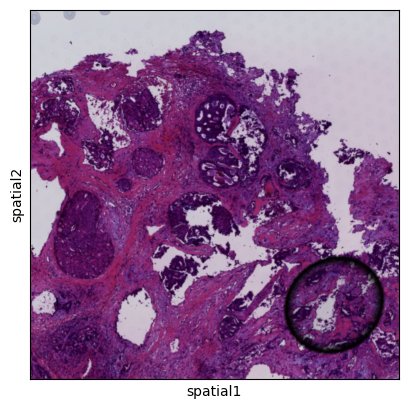

In [162]:
bbox2 = (6000, 12000, 1500, 7500)
sc.pl.spatial(adata, crop_coord=bbox2)

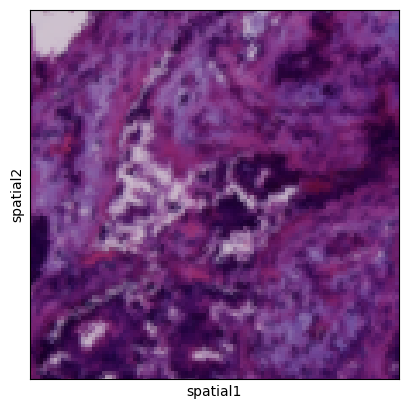

In [169]:
bbox2 = (10000, 11000, 7500, 8500)
sc.pl.spatial(adata, crop_coord=bbox2)

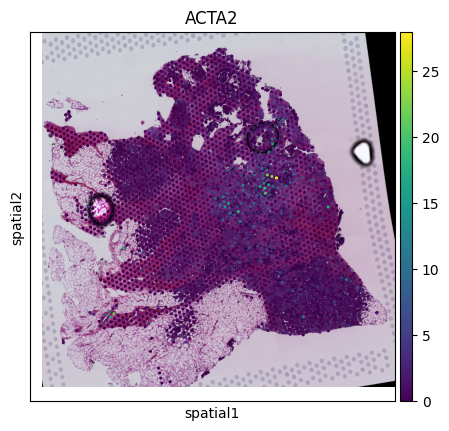

In [166]:
sc.pl.spatial(adata, color='ACTA2')

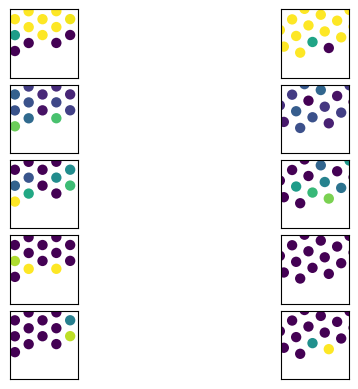

In [160]:
colors = [
    'RCTD_Tumor',
    'RCTD_Fibroblast',
    'RCTD_Macrophage',
    'RCTD_B',
    'RCTD_T',
]
fig, axs = plt.subplots(ncols=len(sid_to_adata), nrows=len(colors))
for c, (sid, adata) in enumerate(sid_to_adata.items()):
    for r, color in enumerate(colors):
        ax = axs[r, c]
        sc.pl.spatial(
            adata, color=color, crop_coord=bbox1, frameon=True, legend_loc=None, colorbar_loc=None,
            ax=ax, title='', show=False, alpha_img=0., size=1., vmax=.5)
        ax.set_ylabel('')
        ax.set_xlabel('')
plt.subplots_adjust(hspace=.1)
        

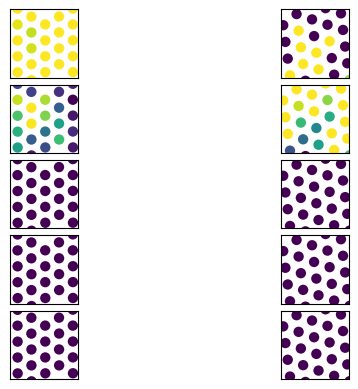

In [170]:
colors = [
    'RCTD_Tumor',
    'RCTD_Fibroblast',
    'RCTD_Macrophage',
    'RCTD_B',
    'RCTD_T',
]
fig, axs = plt.subplots(ncols=len(sid_to_adata), nrows=len(colors))
for c, (sid, adata) in enumerate(sid_to_adata.items()):
    for r, color in enumerate(colors):
        ax = axs[r, c]
        sc.pl.spatial(
            adata, color=color, crop_coord=bbox2, frameon=True, legend_loc=None, colorbar_loc=None,
            ax=ax, title='', show=False, alpha_img=0., size=1., vmax=.5)
        ax.set_ylabel('')
        ax.set_xlabel('')
plt.subplots_adjust(hspace=.1)
        

In [58]:
# only relavent for dinglab data since our channel names are all over the place
# will remove for official example
official_to_options = {
    'Pan-Cytokeratin': ['Pan-Cytokeratin', 'Pan-CK', 'Pan-CK (D)', 'PanCK (D)'],
    'E-cadherin': ['E-cadherin'],
    'CD45': ['CD45 (D)', 'CD45', 'CD45-(D)'],
    'CD45RO': ['CD45RO'],
    'CD45RA': ['CD45RA'],
    'CD8': ['CD8', 'CD8a'],
    'DAPI': ['DAPI'],
    'CD4': ['CD4', 'CD4 (D)'],
    'CD3e': ['CD3e', 'CD3'],
    'Vimentin': ['Vimentin-(D)', 'Vimentin', 'Vimentin (D)'],
    'SMA': ['SMA-(D)', 'SMA', 'SMA (D)', 'a-SMA (D)'],
    'CD31': ['CD31', 'CD31-(D)', 'CD31 (D)'],
    'CD20': ['CD20-(D)', 'CD20', 'CD20 (D)', 'CD20-Akoya'],
    'CD68': ['CD68', 'CD68 (D)', 'CD68-(D)'],
    'CD163': ['CD163'],
    'FOXP3': ['FoxP3', 'FOXP3', 'Foxp3'],
    'cKit': ['cKIT (D)', 'cKit (D)', 'cKit', 'cKIT', 'cKIT-(D)'],
    'MGP': ['MGP', 'MGP (D)', 'MGP-(D)'],
    'CD36': ['CD36-(D)', 'CD36'],
    'PR': ['PR', 'PR-(D)', 'PR (D)'],
    'ER': ['ER', 'ER-(D)', 'ER (D)'],
    'P21': ['P21', 'P21-(D)', 'P21-(D)', 'P21 (D)'],
    'P16': ['P16-(D)'],
    'CK5': ['Keratin 5', 'KRT5'],
    'TFF1': ['TFF1', 'TFF1-(D)', 'TFF1 (D)'],
    'beta-integrin': ['beta-integrin', 'beta3-integrin'],
    'CK14': ['CK14', 'Keratin 14', 'CK14 (D)'],
    'CK17': ['CK17', 'CK17 (D)', 'CK17-(D)', 'Keratin 17'],
    'CK19': ['CK19', 'CK19 (D)', 'CK19-(D)'],
    'CD11b': ['CD11b', 'CD11b (D)', 'CD11b-(D)'],
    'GATA3': ['GATA3', 'GATA3-(D)', 'GATA3 (D)'],
    'PLAT/tPA': ['PLAT/tPA', 'PLAT/tPA (D)'],
    'COX6c': ['COX6c (D)'],
    'Her2': ['Her2', 'Her2 (D)'],
    'Bap1': ['Bap1 (D)'],
    'GLUT1': ['Glut1', 'GLUT1', 'GLUT1-(D)', 'GLUT1 (D)'],
    'CD11c': ['CD11c'],
    'HLA-DR': ['HLA-DR'],
    'Ki67': ['Ki67', 'KI67'],
    'Podoplanin': ['Podoplanin', 'PDPN', 'Podoplanin (D)'],
    'CTLA4': ['CTLA4', 'CTLA4 (D)', 'CTLA4-(D)'],
    'SLC39A6': ['SLC39A6'],
    'BCA1': ['BCA1'],
    'BCAL': ['BCAL'],
    'TUBB3': ['TUBB3', 'TUBB3 (D)'],
    'PTPRZ1': ['PTPRZ1', 'PTPRZ1 (D)'],
    'HIF1A': ['HIF1a', 'HIF1a (D)', 'HIF1A'],
    'PAI1': ['PAI1', 'PAI1-(D)'],
    'GFAP': ['GFAP', 'GFAP (D)'],
    'VEGFA': ['VEGFA', 'VEGFA (D)'],
    'IBA1': ['IBA1', 'IBA1 (D)'],
    'OLIG2': ['OLIG2', 'OLIG2 (D)'],
    'FN1': ['FN1', 'FN1 (D)'],
    'a-Amylase': ['a-Amylase'],
    'Hep-Par-1': ['Hep-Par-1 (D)'],
    'Granzyme-B': ['Granzyme B'],
    'TCF-1': ['TCF-1'],
    'CD39': ['CD39'],
    'PD1': ['PD-1'],
    'PDL1': ['PD-L1'],
    'Histone-H3-Pho': ['Histone H3 Pho'],
    'Maspin': ['Maspin'],
    'MMP9': ['MMP9'],
    'CD44': ['CD44'],
    'CD107A': ['CD107a'],
    'FGFR3': ['FGFR3'],
    'CD138': ['CD138'],
    'MLPH': ['MLPH'],
    'P63': ['P63'],
    'GP2': ['GP2'],
    'COX2': ['COX2'],
    'Lyve-1': ['Lyve-1'],
}
channel_mapping = {v:k for k, vs in official_to_options.items() for v in vs}

In [59]:
config

[{'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium.h5ad'},
   {'dtype': 'visium',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s0_visium_processed.h5ad'}],
  'id': 's0',
  'position': 0},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s1_multiplex.ome.tiff'}],
  'id': 's1',
  'position': 5},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s2_multiplex.ome.tiff'}],
  'id': 's2',
  'position': 55},
 {'data': [{'dtype': 'he',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium.h5ad'},
   {'dtype': 'visium',
    'filepath': '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s3_visium_processed.h5ad'}],
  'id': 's3',
  'position': 100},
 {'data': [{'dtype': 'multiplex',
    'filepath': '/data/estorr

In [70]:
import mushroom.data.multiplex as multiplex
scale = .1
learner_data = multiplex.get_learner_data(
    config, scale, (256, 256), 32,
    channels=None, channel_mapping=channel_mapping
)

In [63]:
learner_data.channels

['Bap1',
 'CD31',
 'CD45',
 'CD68',
 'CD8',
 'CK14',
 'CK19',
 'COX6c',
 'DAPI',
 'ER',
 'FOXP3',
 'GATA3',
 'GLUT1',
 'HLA-DR',
 'Her2',
 'Ki67',
 'MGP',
 'PLAT/tPA',
 'PR',
 'Pan-Cytokeratin',
 'Podoplanin',
 'SMA',
 'Vimentin',
 'cKit']

In [77]:
import torchvision.transforms.functional as TF
def rescale(x, scale=.1):
    if not isinstance(x, torch.Tensor):
        x = torch.tensor(x)
    x = rearrange(x, 'h w c -> c h w')
    x = TF.resize(x, (int(x.shape[-2] * scale), int(x.shape[-1] * scale)), antialias=True)
    x = rearrange(x.numpy(), 'c h w -> h w c')    
    return x

In [82]:
channel_to_img.keys()

dict_keys(['DAPI', 'Pan-Cytokeratin', 'SMA-(D)', 'CD45 (D)'])

In [78]:
filepath = '/data/estorrs/mushroom/data/projects/subclone/registered/HT397B1/s1_multiplex.ome.tiff'

In [83]:
multiplex.get_common_channels([filepath])

['Bap1 (D)',
 'CD20-(D)',
 'CD31',
 'CD45 (D)',
 'CD68 (D)',
 'CD8',
 'CK19',
 'COX6c (D)',
 'DAPI',
 'ER',
 'FoxP3',
 'GATA3 (D)',
 'GLUT1-(D)',
 'HLA-DR',
 'Her2 (D)',
 'Keratin 14',
 'Ki67',
 'MGP-(D)',
 'PLAT/tPA (D)',
 'PR-(D)',
 'Pan-Cytokeratin',
 'Podoplanin',
 'SMA-(D)',
 'Vimentin-(D)',
 'cKIT-(D)']

In [108]:
multiplex_cmap = {
    'Pan-Cytokeratin': (1., 0., 0.),
    'CD45 (D)': (0., 1., 0.),
    'SMA-(D)': (1., 1., 1.),
    'CD8': (1., 1., 0.)
}

contrast_mapping = {
    'Pan-Cytokeratin': 90.,
    'CD45 (D)': 95.,
    'SMA-(D)': 90.,
    'CD8': 90.
}

c1, c2, r1, r2 = [x for x in bbox1]
channel_to_img = multiplex.extract_ome_tiff(filepath, channels=list(multiplex_cmap.keys()))
channel_to_img = {channel:img[r1:r2, c1:c2] for channel, img in channel_to_img.items()}
# channel_to_img = {channel:np.squeeze(rescale(np.expand_dims(img, -1), scale=scale))
#      for channel, img in channel_to_img.items()}

pseudo = multiplex.make_pseudo(channel_to_img, cmap=multiplex_cmap, contrast_pct=90., contrast_mapping=contrast_mapping)
pseudo /= pseudo.max()
pseudo.shape

(6000, 6000, 3)

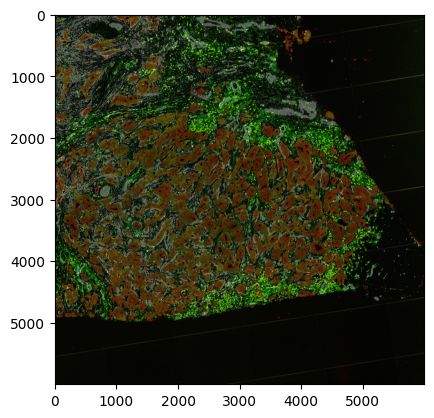

In [109]:
plt.imshow(pseudo)

In [64]:
img = learner_data.section_to_img['s1']

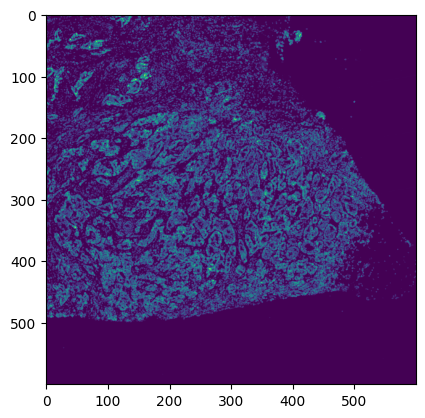

In [72]:
c1, c2, r1, r2 = [int(x * scale) for x in bbox1]
plt.imshow(img[learner_data.channels.index('Pan-Cytokeratin'), r1:r2, c1:c2])

In [71]:
c1, c2, r1, r2 = [int(x * scale) for x in bbox1]

In [17]:
ds = mushroom.learner.train_ds

In [30]:
import cProfile
cProfile.run('ds[0]', sort=2)

         5886 function calls (5883 primitive calls) in 0.156 seconds

   Ordered by: cumulative time

   ncalls  tottime  percall  cumtime  percall filename:lineno(function)
        1    0.000    0.000    0.156    0.156 {built-in method builtins.exec}
        1    0.000    0.000    0.156    0.156 <string>:1(<module>)
        1    0.000    0.000    0.156    0.156 visium.py:283(__getitem__)
        1    0.005    0.005    0.155    0.155 visium.py:236(__call__)
        3    0.062    0.021    0.137    0.046 visium.py:59(format_expression)
      170    0.033    0.000    0.033    0.000 visium.py:85(<listcomp>)
      6/3    0.000    0.000    0.015    0.005 _jit_internal.py:474(fn)
        3    0.000    0.000    0.015    0.005 functional.py:879(_return_output)
        3    0.000    0.000    0.015    0.005 functional.py:722(_unique_impl)
        3    0.015    0.005    0.015    0.005 {built-in method unique_dim}
        5    0.012    0.002    0.012    0.002 {built-in method torch.stack}
      170